#  Chargement des données — Expérience 2 (Crossing)

Cette première cellule initialise l’environnement analytique pour l’étude *Crossing* :

###  Connexion à la base de données
- Connexion MySQL via `get_py_db_connection()`.
- Récupération des tables :
  - **Crossing** → comportements de traversée + distances + météos + vitesses.
  - **Participant** → caractéristiques individuelles.

###  Préparation des données
- Suppression des valeurs manquantes.
- Conversion des vitesses (km/h → m/s).
- Catégorisation des vitesses (low, medium, high).
- Construction de variables dérivées :
  - `T_end` : temps restant avant que la voiture atteigne le piéton au moment critique.
  - `D_end` : distance critique (safety_distance).

###  Fusion avec les données participants
La table *Crossing* est enrichie avec l’âge, la taille, le sexe, le permis, etc., pour permettre des analyses croisées.

Cette cellule crée ainsi la **dataframe principale `df`**, utilisée dans toutes les analyses suivantes.


In [345]:
# Obtenir une connexion et un curseur
from db_utils import get_py_db_connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene, kruskal, f_oneway, pearsonr, ttest_ind, mannwhitneyu
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import r2_score

conn, cursor = get_py_db_connection()

query = "SELECT * FROM Crossing;"
cursor.execute(query)
columns = [col[0] for col in cursor.description]
df = pd.DataFrame(cursor.fetchall(), columns=columns)
df = df.dropna()

velocity_groups = {
    'low': [20.0, 30.0],
    'medium': [40.0, 50.0],
    'high': [60.0, 70.0]
}

def get_velocity_category(velocity_id):
    for category, velocities in velocity_groups.items():
        if velocity_id in velocities:
            return category
    return 'unknown'

df['velocity_ms'] = df['velocity_id'] * (5 / 18)
df['velocity_group'] = df['velocity_id'].apply(get_velocity_category)
df['velocity_cat'] = df['velocity_id'].astype(int).astype(str) + " km/h"
df['T_end'] = df['safety_distance'] / df['velocity_ms']
df['D_end'] = df['safety_distance']

query = "SELECT * FROM Participant;"
cursor.execute(query)
columns = [col[0] for col in cursor.description]
df_part = pd.DataFrame(cursor.fetchall(), columns=columns)
df_part = df_part.dropna()

df = df.merge(df_part, on='participant_id', how='left')

#  Configuration du style graphique & création des palettes de couleurs

Cette cellule définit l’apparence générale de toutes les visualisations du notebook
et crée des jeux de couleurs cohérents pour les différentes variables de l’étude.

###  1. Style global des figures
Les options `matplotlib` et `seaborn` :
- adoptent un thème clair *whitegrid*,
- utilisent la police **Times New Roman**,
- activent la compilation LaTeX pour un rendu typographique propre,
- assurent une haute résolution (300 dpi),
- garantissent des marges automatiques.

###  2. Palettes de couleurs personnalisées
Création de palettes dédiées pour :
- **sex** (homme/femme),
- **driver_license** (0 / 1),
- **weather_id** (“rain”, “clear”, “night”),
- **velocity_id** (chaque vitesse reçoit une couleur unique).

Ces palettes assurent une cohérence visuelle entre toutes les figures du notebook.

###  3. Catégorisation des âges et des tailles
Les variables continues `age` et `height` sont :
- discrétisées dans des intervalles (`pd.cut`)
- associées à des couleurs via des *palettes graduelles* (Greens / Blues)
- stockées dans :
  - `Age_bin` / `Height_bin` : intervalle
  - `Age_color` / `Height_color` : couleur associée

Cela permet d'utiliser la couleur comme encodage visuel dans des scatterplots.

###  4. Définition des types de variables
La cellule prépare aussi :
- les variables continues : `velocity_id`, `height`, `age`
- les variables binaires : `sex`, `driver_license`
- les variables catégorielles : `weather_id`
- une liste complète `all_group_vars` utile pour automatiser des analyses croisées

###  5. Définition des couples de variables à analyser
La liste `crosses` prépare un ensemble standardisé de comparaisons :
- catégorielle × catégorielle
- catégorielle × continue
- continue × continue

Ces paires seront utilisées plus tard pour générer automatiquement des graphiques
et des tests statistiques entre toutes les variables pertinentes.

En résumé, cette cellule construit **toute l’infrastructure esthétique et catégorielle**
qui servira à uniformiser les analyses et figures du notebook.


In [346]:
sns.set_theme(style="whitegrid")

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "text.usetex": True,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "figure.autolayout": True
})

binary_palette = {
    "Man": "#fbb4ae",
    "Woman": "#b3cde3",
    "1.0": "#fdcdac",
    "0.0": "#b3e2cd"
}

weather_palette = {
    "clear": "#ffffb3",
    "rain": "#8dd3c7",
    "night": "#bebada"
}

velocity_palette = {
    20.0: "#66c2a5",
    30.0: "#fc8d62",
    40.0: "#8da0cb",
    50.0: "#e78ac3",
    60.0: "#a6d854",
    70.0: "#ffd92f"
}

age_bins = pd.IntervalIndex([
    pd.Interval(20.999, 26.0, closed='right'),
    pd.Interval(26.0, 27.0, closed='right'),
    pd.Interval(27.0, 32.0, closed='right'),
    pd.Interval(32.0, 62.0, closed='right')
])
age_colors = sns.color_palette("Greens", n_colors=len(age_bins)).as_hex()
age_palette = dict(zip(age_bins, age_colors))

height_bins = pd.IntervalIndex([
    pd.Interval(156.999, 167.0, closed='right'),
    pd.Interval(167.0, 171.0, closed='right'),
    pd.Interval(171.0, 176.0, closed='right'),
    pd.Interval(176.0, 180.0, closed='right'),
    pd.Interval(180.0, 190.0, closed='right')
])
height_colors = sns.color_palette("Blues", n_colors=len(height_bins)).as_hex()
height_palette = dict(zip(height_bins, height_colors))

def map_interval_to_color(value, palette):
    for interval, color in palette.items():
        if value == interval:
            return color
    return "#000000"  # fallback

df['Age_bin'] = pd.cut(df['age'], bins=age_bins)
df['Height_bin'] = pd.cut(df['height'], bins=height_bins)

df['Age_color'] = df['Age_bin'].apply(lambda x: map_interval_to_color(x, age_palette))
df['Height_color'] = df['Height_bin'].apply(lambda x: map_interval_to_color(x, height_palette))

variables = ['T_end', 'D_end']
continuous_vars = ['velocity_id', 'height', 'age']
binary_cats = ['sex', 'driver_license']
multi_cats = ['weather_id']

all_group_vars = continuous_vars + binary_cats + multi_cats

crosses = [
    # Catégorielle vs Catégorielle
    ('weather_id', 'sex'),
    ('weather_id', 'driver_license'),
    ('sex', 'driver_license'),

    # Catégorielle vs Continue
    ('weather_id', 'velocity_id'),
    ('weather_id', 'height'),
    ('weather_id', 'age'),
    ('sex', 'velocity_id'),
    ('sex', 'height'),
    ('sex', 'age'),
    ('driver_license', 'velocity_id'),
    ('driver_license', 'height'),
    ('driver_license', 'age'),

    # Continue vs Continue
    ('velocity_id', 'height'),
    ('velocity_id', 'age'),
    ('height', 'age')
]




#  Statistiques descriptives globales des variables d’intérêt

Cette cellule définit la fonction `descriptives_globales_compare`, utilisée pour examiner
de manière détaillée les distributions des variables continues principales de l’expérience 2,
à savoir :

- **T_end** : temps seuil de sécurité (s)  
- **D_end** : distance seuil de sécurité (m)

L’analyse inclut :


##  1. Statistiques de base
Pour chaque variable examinée, la fonction affiche :

- nombre d’observations  
- moyenne, médiane  
- écart-type  
- quartiles (Q1, Q3)  
- min / max  

Ces informations permettent d’évaluer la variabilité des comportements de crossing.


##  2. Histogrammes + estimation de densité KDE

La fonction génère pour chaque variable :

- un **histogramme**,
- une **courbe KDE** (Gaussian Kernel Density Estimator),
- deux indicateurs visuels essentiels :
  - **mode KDE** (maximum de la densité estimée) — ligne noire pointillée
  - **médiane** ligne rouge en pointillés

Ces annotations servent à comparer rapidement :
- la symétrie de la distribution,
- la présence d’asymétrie ou de multimodalité,
- la différence entre médiane et mode (indiquant potentiellement une estimation biaisée).


##  3. QQ-plots (Normalité visuelle)

Pour vérifier visuellement si les distributions suivent une loi normale,
la fonction génère des **QQ-plots** (`statsmodels.qqplot`).

Cela complète les tests statistiques plus formels.


##  4. Tests de normalité (Shapiro-Wilk)

Pour chaque variable, le test de **Shapiro–Wilk** évalue si la distribution est compatible
avec une loi normale.

- **p > 0.05** → normalité plausible  
- **p < 0.05** → normalité rejetée  

Cette information guidera les choix de tests statistiques ultérieurs (tests paramétriques vs non-paramétriques).


##  5. Exécution sur T_end et D_end

La commande :

```python
descriptives_globales_compare(df, variables)
```

lance l’analyse complète pour les deux variables centrales :

* **T_end (temps limite)**
* **D_end (distance limite)**

Ce bloc constitue donc une première exploration indispensable avant les analyses
plus fines (comparaisons inter-conditions, modèles mixtes, corrélations, etc.).


In [347]:
import matplotlib.lines as mlines

def descriptives_globales_compare(df, vars_list, colors=None):
    import scipy.stats as stats
    import statsmodels.api as sm
    from scipy.stats import shapiro
    import numpy as np
    import matplotlib.pyplot as plt

    if colors is None:
        colors = ["#1f77b4", "#ff7f0e"]

    n = len(vars_list)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1:
        axes = [axes]

    for ax, var, color in zip(axes, vars_list, colors):
        print(f"Descriptive statistics for {var}")
        print(df[var].describe())
        print("Median:", df[var].median())
        print("Quartiles (Q1, Q3):", df[var].quantile([0.25, 0.75]))

        sns.histplot(df[var].dropna(), kde=True, color=color, ax=ax)
        kde = stats.gaussian_kde(df[var].dropna())
        x_vals = np.linspace(df[var].min(), df[var].max(), 1000)
        kde_vals = kde(x_vals)
        peak_x = x_vals[np.argmax(kde_vals)]
        
        line_peak = ax.axvline(peak_x, color='black', linestyle='--')
        line_median = ax.axvline(df[var].median(), color='red', linestyle=':')
        ax.set_title(f"Histogram of {var}")

        # Créer une légende avec les lignes et leur label explicite
        legend_lines = [
            mlines.Line2D([], [], color='black', linestyle='--', label=f"Mode KDE = {peak_x:.2f}"),
            mlines.Line2D([], [], color='red', linestyle=':', label=f"Median = {df[var].median():.2f}")
        ]
        ax.legend(handles=legend_lines)

    plt.tight_layout()
    plt.show()

    # QQ plots
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1:
        axes = [axes]

    for ax, var, color in zip(axes, vars_list, colors):
        sm.qqplot(df[var].dropna(), line='s', ax=ax, color=color)
        ax.set_title(f"QQ-Plot of {var}")

    plt.tight_layout()
    plt.show()

    # Shapiro-Wilk test
    for var in vars_list:
        stat, p = shapiro(df[var].dropna())
        print(f"Shapiro-Wilk test for {var}: stat={stat:.3f}, p={p:.3f}")


Descriptive statistics for T_end
count    510.000000
mean       4.490535
std        2.354610
min        0.197722
25%        2.985535
50%        3.994314
75%        5.332412
max       18.445080
Name: T_end, dtype: float64
Median: 3.9943144285714283
Quartiles (Q1, Q3): 0.25    2.985535
0.75    5.332412
Name: T_end, dtype: float64
Descriptive statistics for D_end
count    510.000000
mean      49.296023
std       19.101274
min        1.647680
25%       35.275725
50%       46.866500
75%       59.604075
max      153.709000
Name: D_end, dtype: float64
Median: 46.8665
Quartiles (Q1, Q3): 0.25    35.275725
0.75    59.604075
Name: D_end, dtype: float64


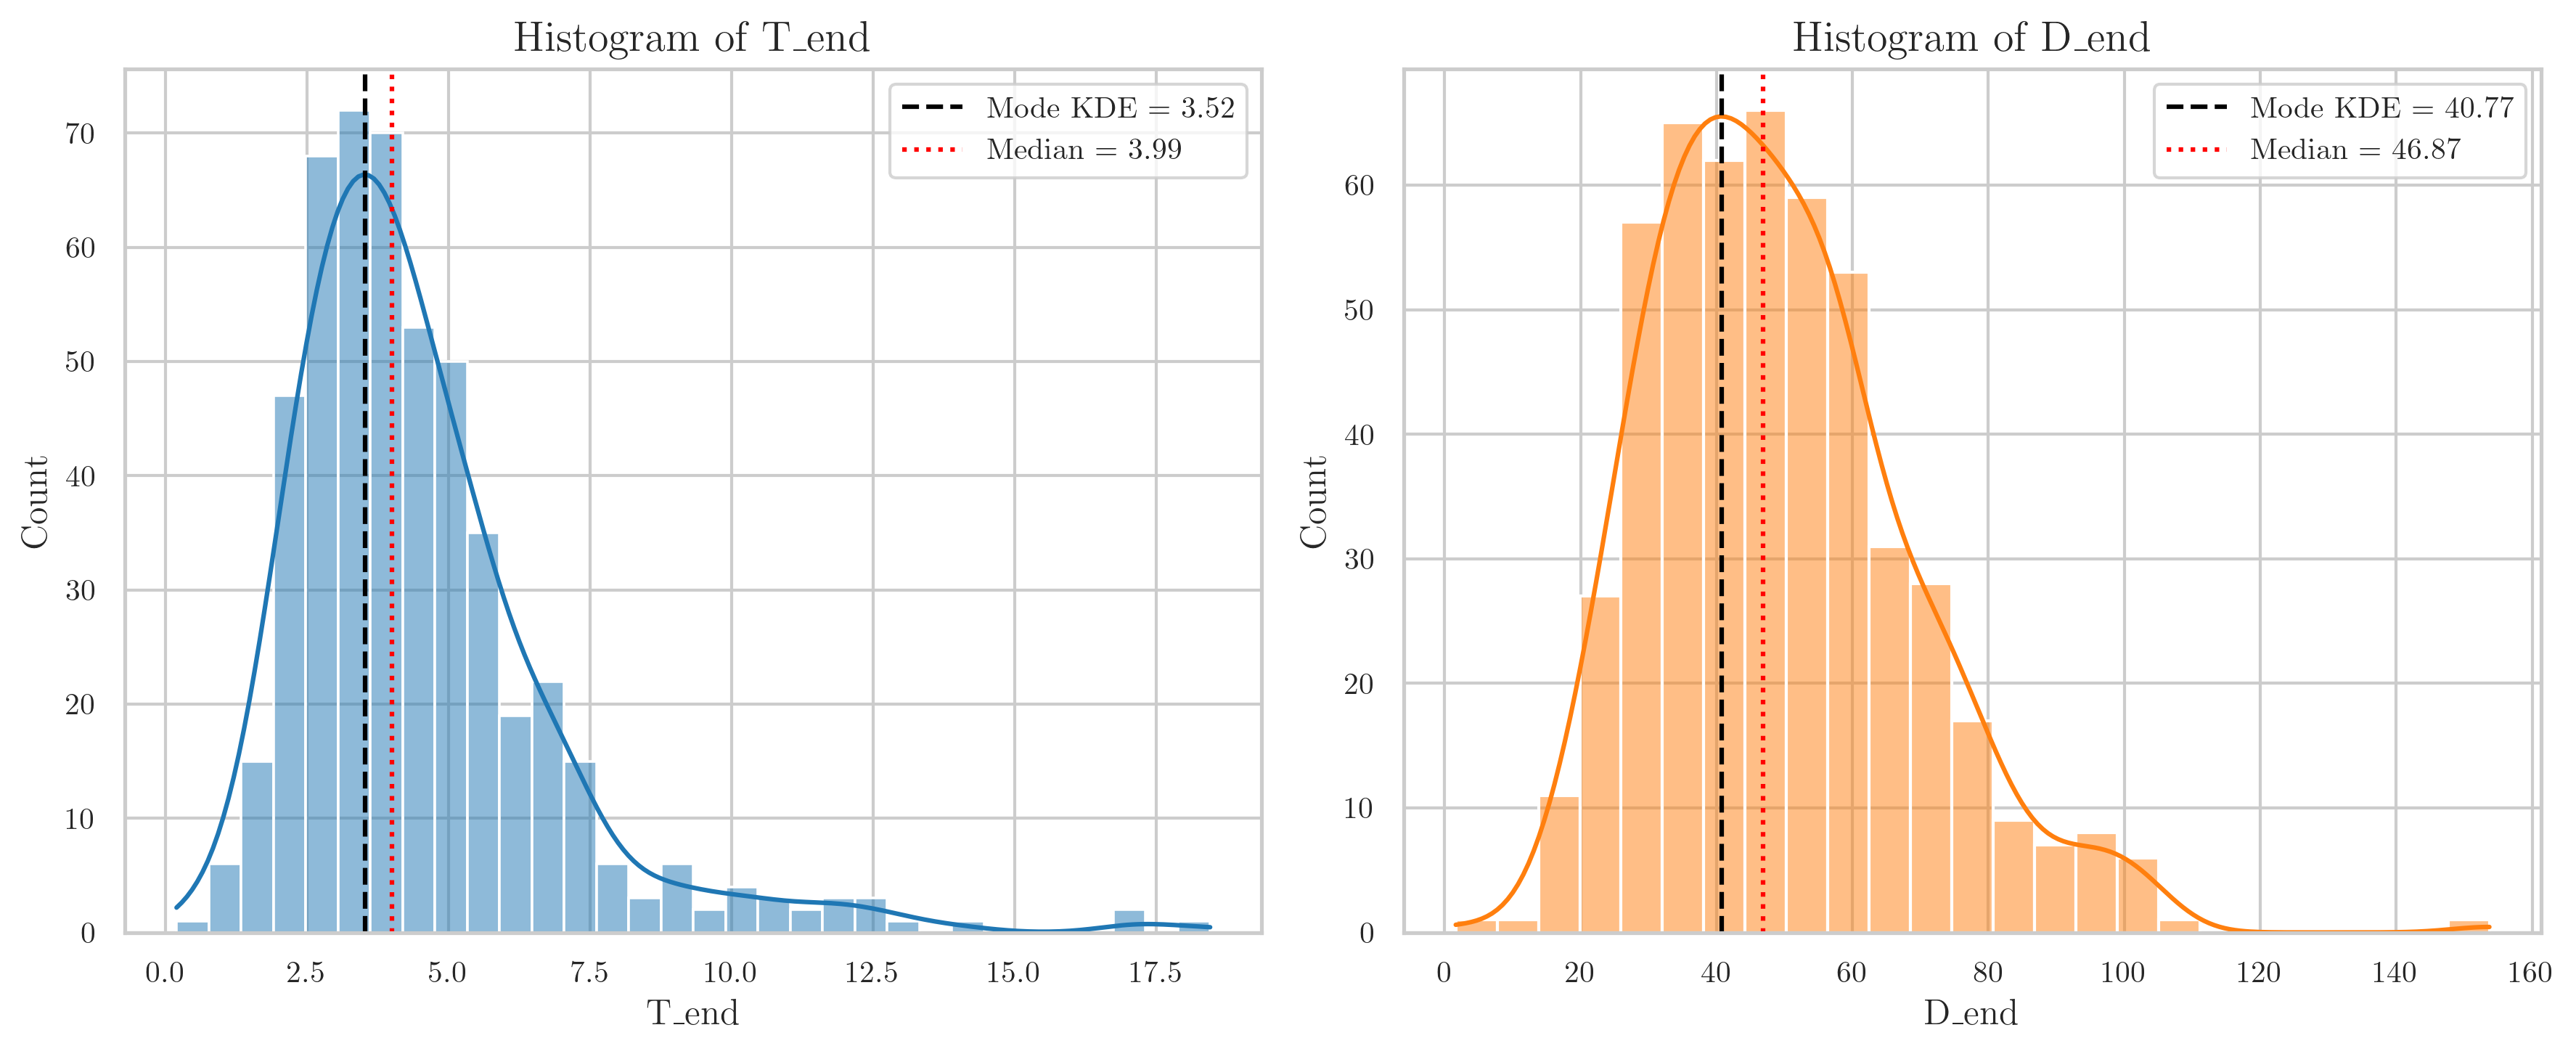

c:\Users\svictor\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


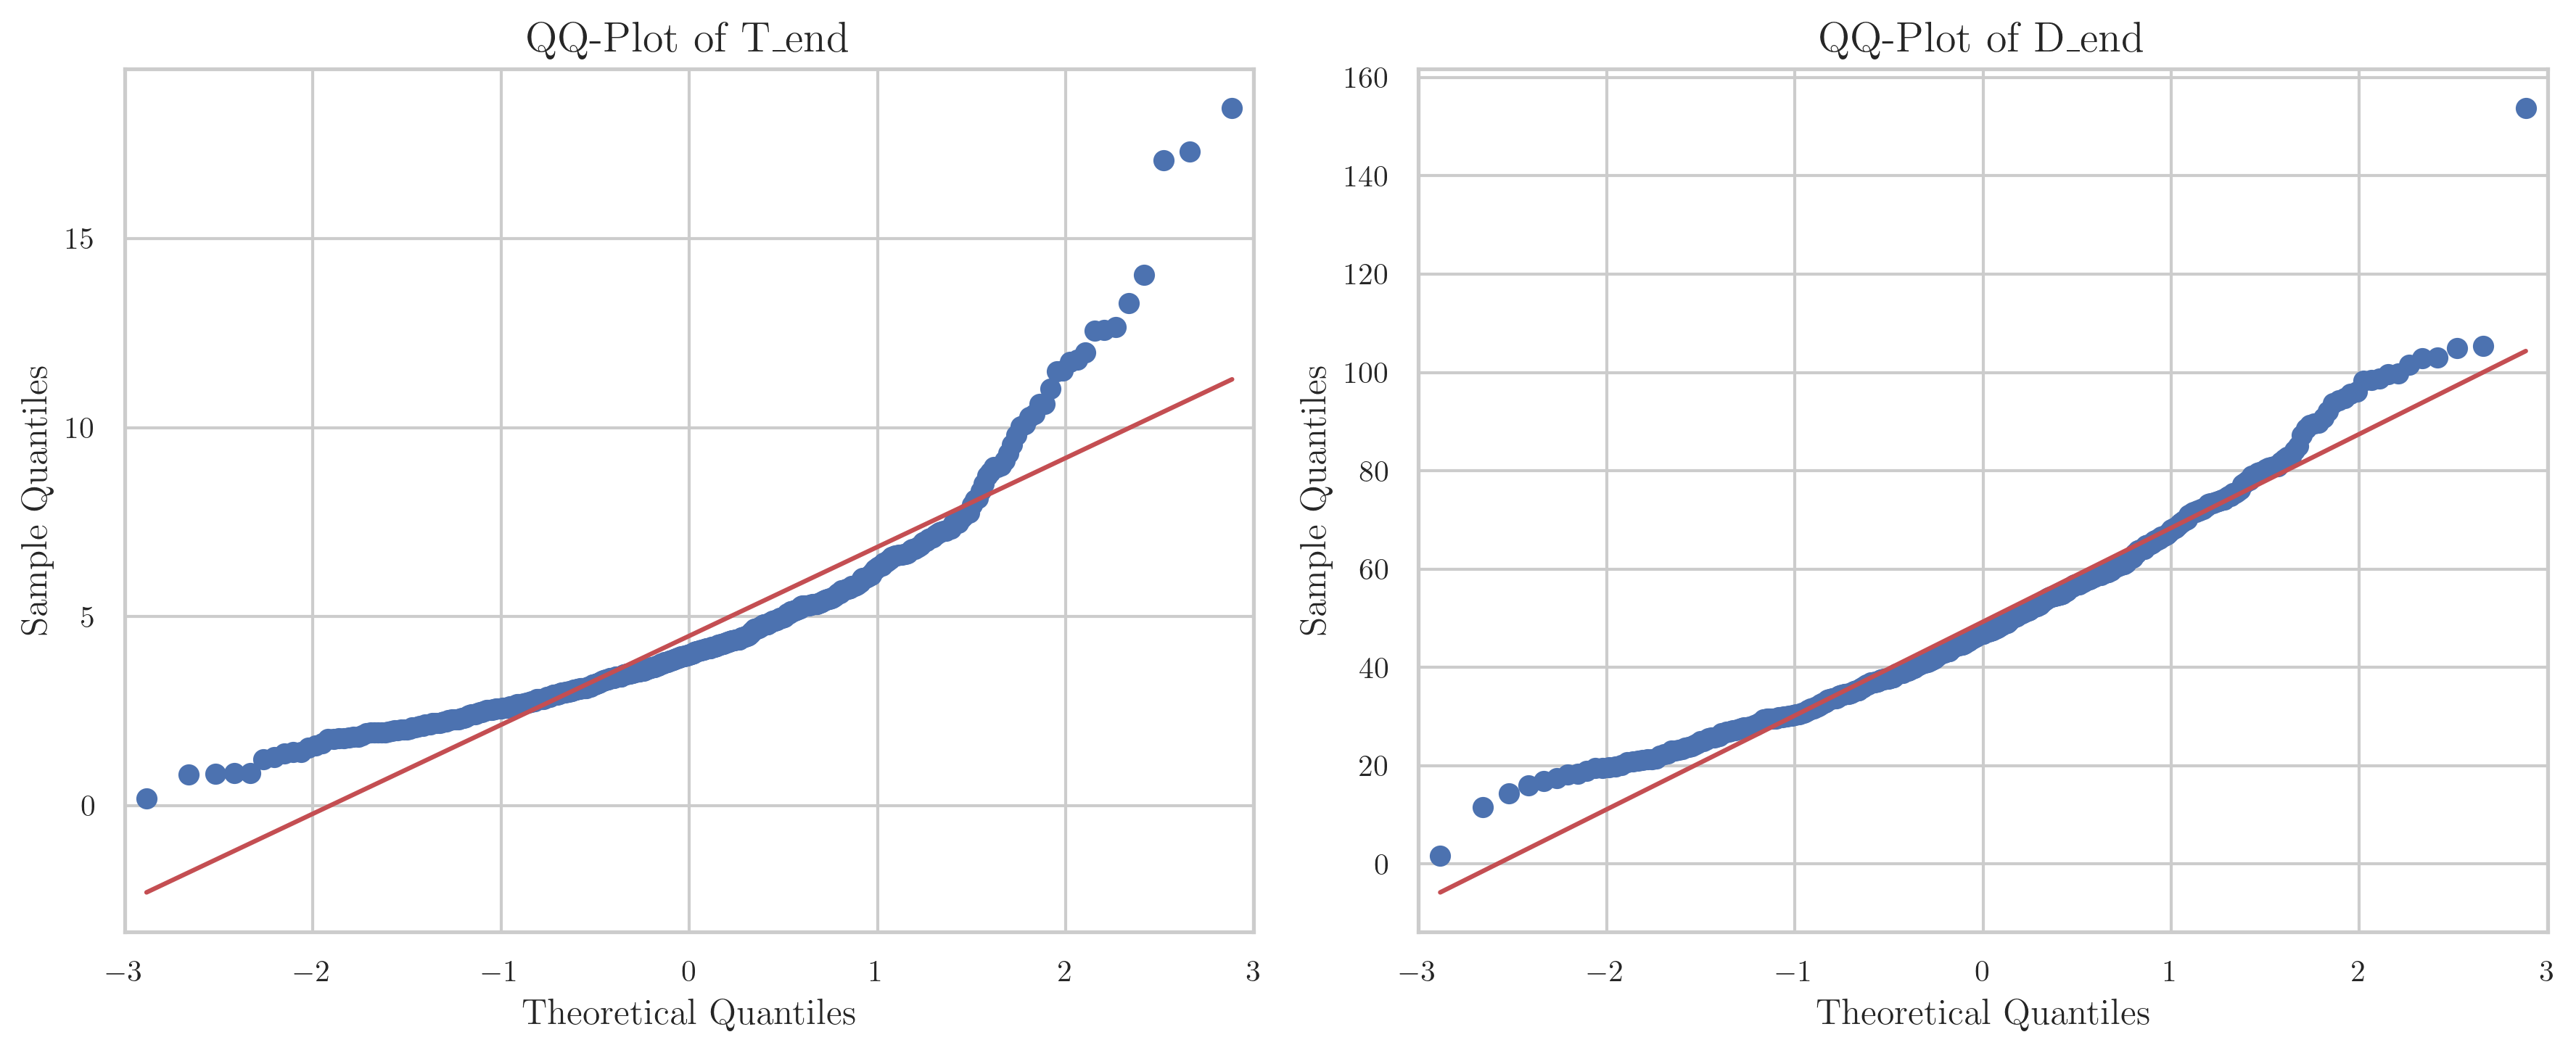

Shapiro-Wilk test for T_end: stat=0.845, p=0.000
Shapiro-Wilk test for D_end: stat=0.960, p=0.000


In [348]:
descriptives_globales_compare(df, variables)

##  Corrélations entre variables continues et seuils de sécurité (T_end, D_end)

Cette cellule introduit la fonction `correlation_and_boxplots_grid_single_poly`, qui réalise une analyse
complète des relations entre les deux variables dépendantes principales de l'expérience 2 :

- **T_end** : Temps limite de sécurité (TTC maximal)
- **D_end** : Distance limite de sécurité

… et plusieurs variables continues expliquant potentiellement ces seuils :

- vitesse du véhicule (**velocity_id**)
- taille du participant (**height**)
- âge du participant (**age**)

L’analyse combine à la fois :


##  1. *Scatterplots* avec régression polynomiale
Pour chaque couple *(variable continue → T_end / D_end)*, le script :

- trace un **nuage de points**,
- ajuste un **polynôme** :
  - degré 1 pour vitesse et âge,
  - degré 2 pour la taille (cas où une non-linéarité est supposée plausible),
- affiche la **courbe de régression** (rouge),
- calcule :
  - **coefficients du polynôme**
  - **R² du modèle**
  - **test de normalité des résidus (Shapiro-Wilk)**

Ces résultats permettent d’évaluer :
- la force de la relation,
- sa forme (linéaire / courbée),
- si un modèle linéaire/polynomial est statistiquement acceptable.


##  2. Boxplots par classes de variables continues
Pour interpréter les effets des variables continues sous forme catégorique,
la fonction génère aussi des **boxplots** :

- vitesse : 20/30/40/50/60/70 km/h  
- âge : réparti en **quartiles**
- taille : répartie en **quartiles**

Cela permet de visualiser :
- la dispersion de T_end / D_end selon chaque groupe,
- la présence éventuelle d’effets monotones ou non-linéaires,
- les tendances selon les profils individuels.


##  3. Résumé textuel des modèles
Pour chaque combinaison *(variable continue → variable cible)*, la fonction affiche :

- degré du polynôme utilisé  
- **R²**  
- **p-value Shapiro sur les résidus**  

Si *p < 0.05*, les résidus s’écartent de la normalité → l’interprétation du modèle doit être faite avec prudence.


##  4. Exécution sur l’ensemble des variables

Les lignes suivantes appliquent l’analyse à :

- `T_end` : temps limite de sécurité  
- `D_end` : distance limite de sécurité  

avec comme variables explicatives :

- vitesse du véhicule  
- hauteur  
- âge  

```python
variables = ['T_end', 'D_end']
continuous_vars = ['velocity_id', 'height', 'age']

correlation_and_boxplots_grid_single_poly(df, variables, continuous_vars)
````


In [349]:
def correlation_and_boxplots_grid_single_poly(df, variables, continuous_vars, label_map=None):
    from scipy.stats import shapiro

    # Palettes
    velocity_palette_str = {f"{int(k)} km/h": v for k, v in velocity_palette.items()}
    age_quartile_palette = sns.color_palette("Greens", n_colors=4).as_hex()
    height_quartile_palette = sns.color_palette("Blues", n_colors=4).as_hex()

    # Labels personnalisés
    if label_map is None:
        label_map = {
            'velocity_id': 'Ego-Vehicle Speed',
            'age': 'Participant Age',
            'height': 'Participant Height',
            'T_end': 'T_end',
            'D_end': 'D_end'
        }

    ordered_velocity_cat = [f"{int(k)} km/h" for k in sorted(velocity_palette.keys())]
    df['velocity_cat'] = df['velocity_id'].apply(lambda v: f"{int(v)} km/h")
    df['velocity_cat'] = pd.Categorical(df['velocity_cat'], categories=ordered_velocity_cat, ordered=True)

    degree_map = {
        'velocity_id': 1,
        'height': 2,
        'age': 1
    }

    best_models = {}

    # Scatterplots
    fig_scatter, axes_scatter = plt.subplots(len(continuous_vars), len(variables), figsize=(12, 15))

    for i, cont_var in enumerate(continuous_vars):
        for j, var in enumerate(variables):
            ax = axes_scatter[i, j]
            df_clean = df[[cont_var, var]].dropna()
            x = df_clean[cont_var].values
            y = df_clean[var].values
            deg = degree_map.get(cont_var, 1)

            sns.regplot(x=x, y=y, ax=ax,
                        order=deg,
                        scatter_kws={'alpha': 0.6},
                        line_kws={'color': 'red', 'lw': 2})

            coeffs = np.polyfit(x, y, deg)
            poly = np.poly1d(coeffs)
            y_pred = poly(x)
            r2 = r2_score(y, y_pred)
            resid = y - y_pred
            stat, p_val = shapiro(resid)

            best_models[(var, cont_var)] = (deg, r2, p_val)

            ax.set_title(f"{label_map.get(var, var)} vs {label_map.get(cont_var, cont_var)} (poly deg {deg})")
            ax.set_xlabel(label_map.get(cont_var, cont_var))
            ax.set_ylabel(label_map.get(var, var))

    plt.tight_layout()
    plt.show()

    # Boxplots
    fig_box, axes_box = plt.subplots(len(continuous_vars), len(variables), figsize=(12, 15))

    for i, cont_var in enumerate(continuous_vars):
        for j, var in enumerate(variables):
            ax = axes_box[i, j]

            if cont_var == 'velocity_id':
                sns.boxplot(x='velocity_cat', y=var, data=df, palette=velocity_palette_str, ax=ax)
                ax.set_xlabel(label_map.get('velocity_id', 'velocity_id'))
            elif cont_var in ['age', 'height']:
                df['quartile'] = pd.qcut(df[cont_var], 4)
                quartiles = df['quartile'].cat.categories

                colors_palette = age_quartile_palette if cont_var == 'age' else height_quartile_palette
                palette_for_boxplot = {str(q): color for q, color in zip(quartiles, colors_palette)}

                df['quartile'] = df['quartile'].astype(str)
                cat_type = pd.api.types.CategoricalDtype(categories=list(palette_for_boxplot.keys()), ordered=True)
                df['quartile'] = df['quartile'].astype(cat_type)

                sns.boxplot(x='quartile', y=var, data=df, palette=palette_for_boxplot, ax=ax)
                ax.set_xlabel(f"{label_map.get(cont_var, cont_var)} quartiles")

                df.drop('quartile', axis=1, inplace=True)
            else:
                sns.boxplot(x=cont_var, y=var, data=df, ax=ax)

            ax.set_title(f"{label_map.get(var, var)} by {label_map.get(cont_var, cont_var)}")
            ax.set_ylabel(label_map.get(var, var))

    plt.tight_layout()
    plt.show()

    # Résumé console
    for (var, cont_var), (deg, r2, p_val) in best_models.items():
        print(f"Polynomial model for {var} vs {cont_var}: degree {deg} with R² = {r2:.3f}")
        print(f"Residual normality (Shapiro p) = {p_val:.3f}")
        if p_val < 0.05:
            print("→ Residuals non-normal, interpret with caution.")
        else:
            print("→ Residuals compatible with normal distribution.")


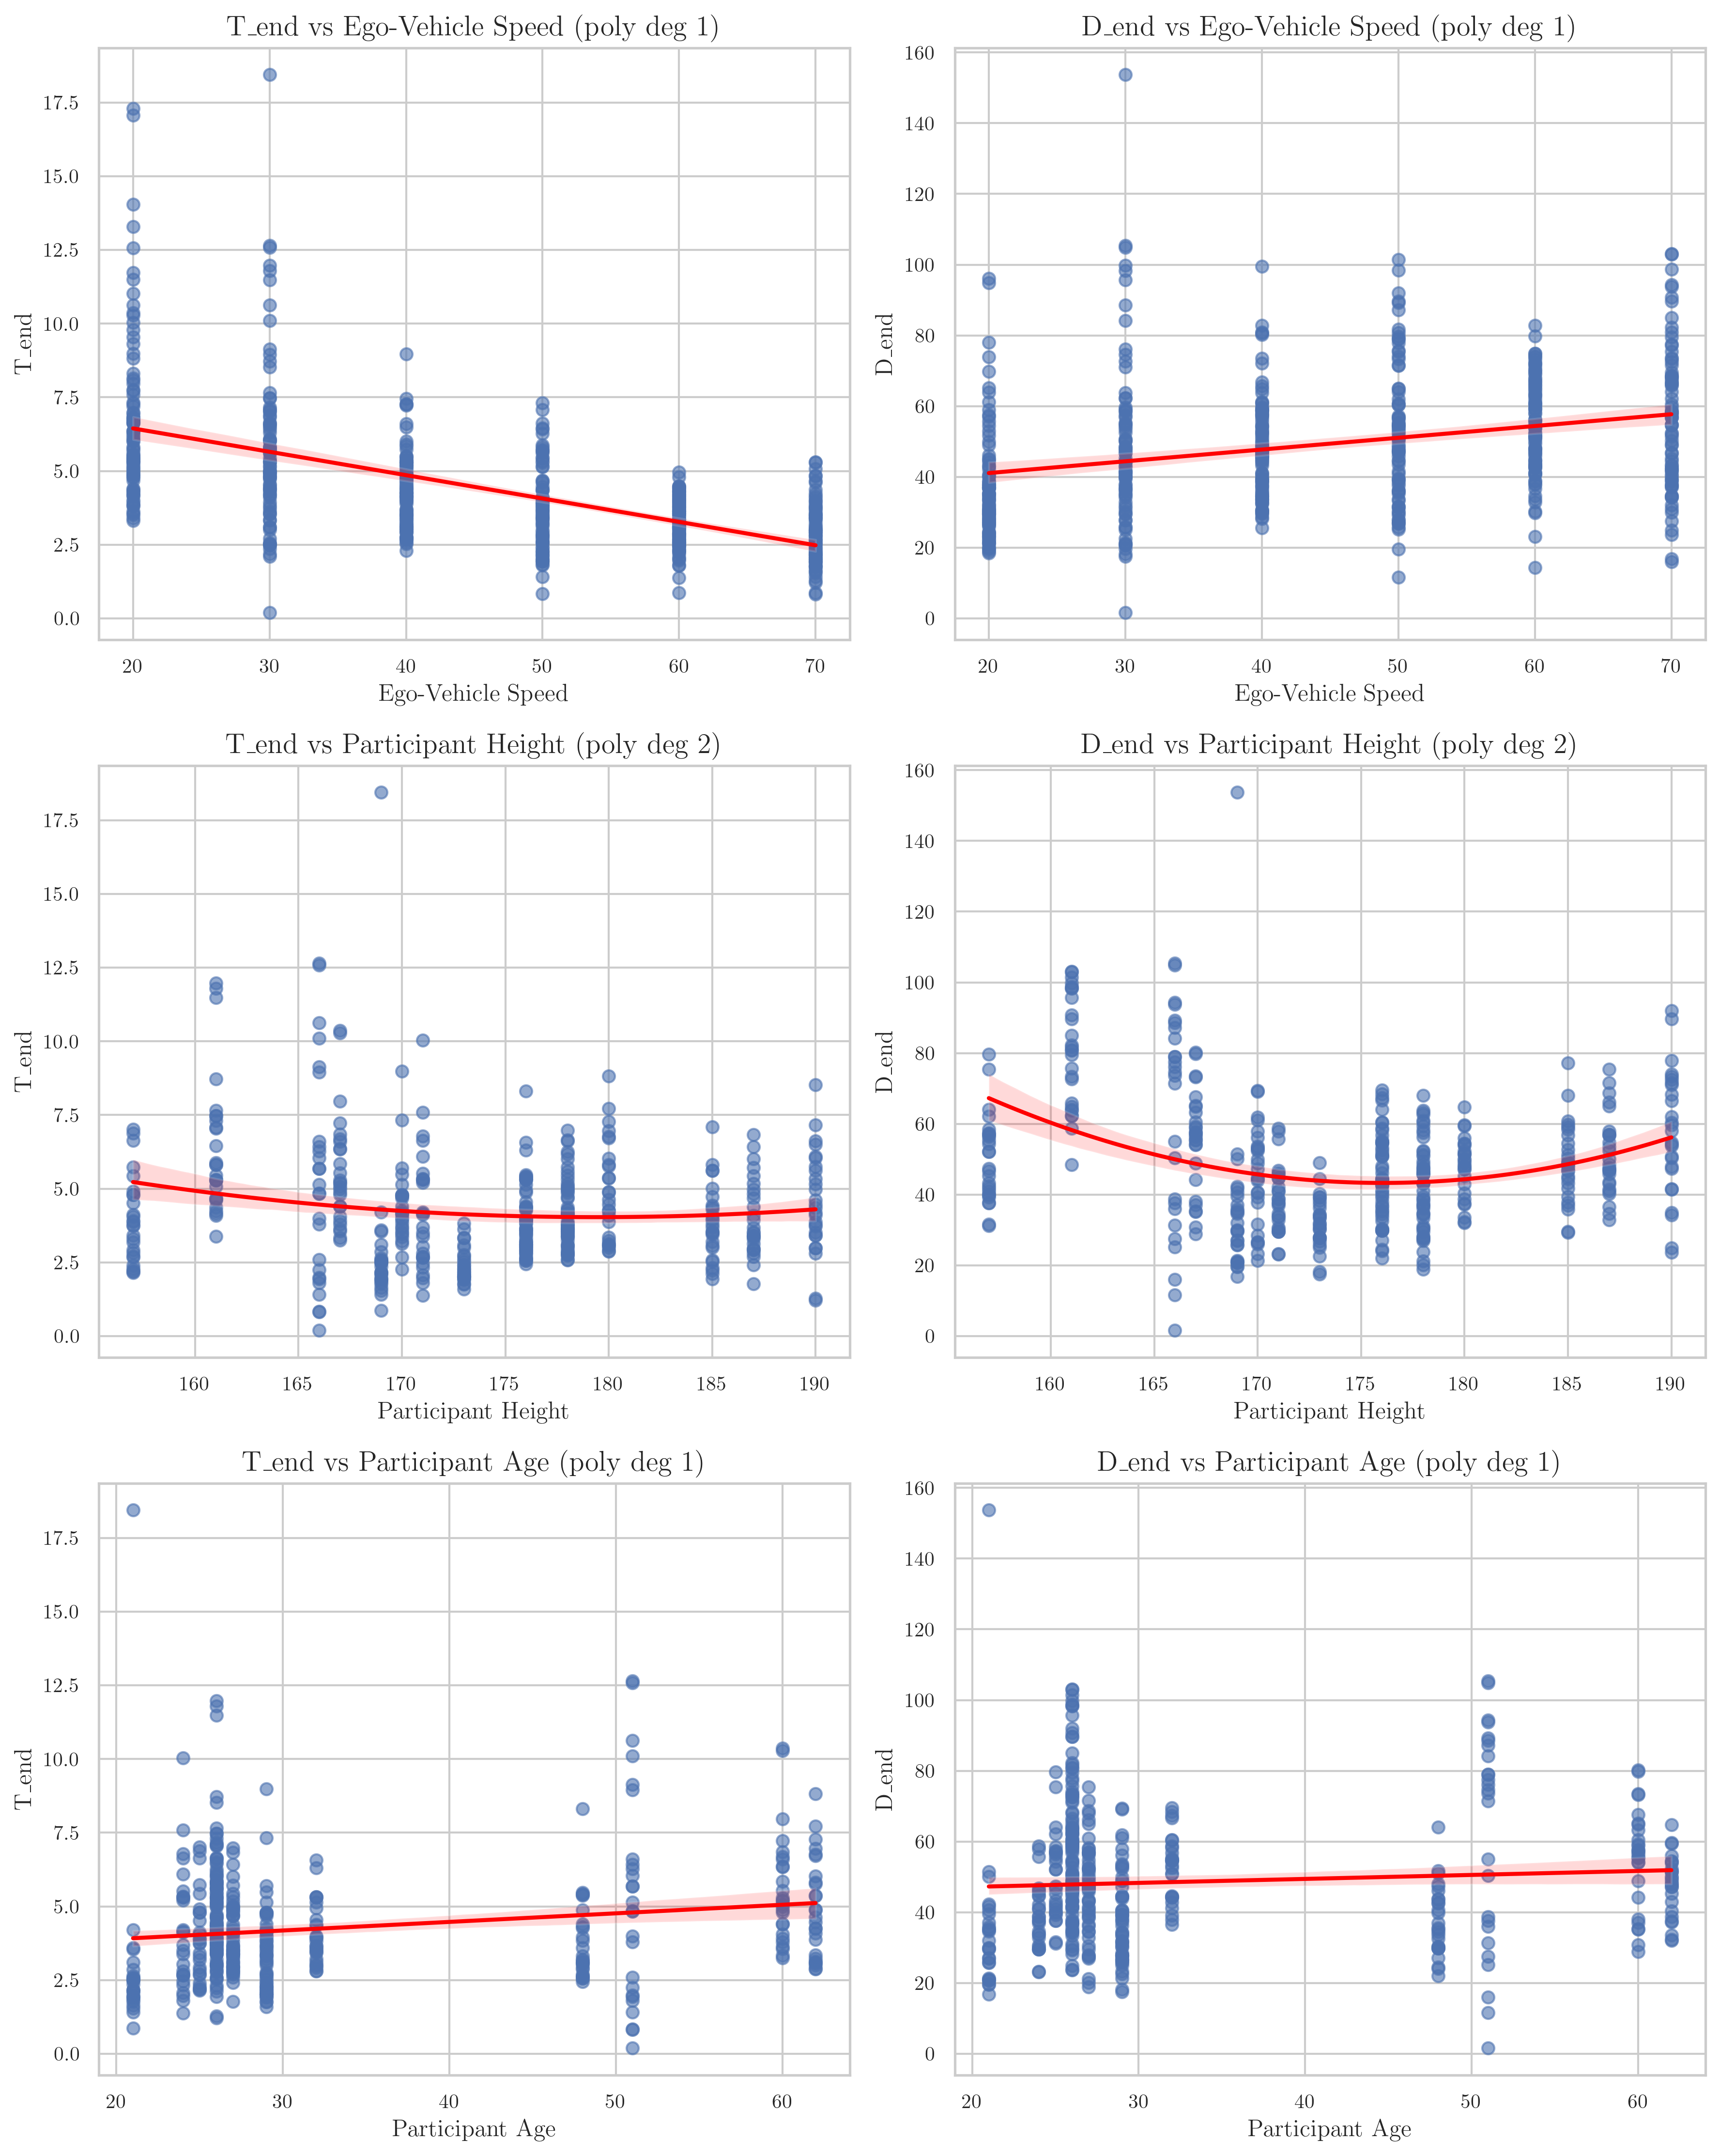

C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\2233105791.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='velocity_cat', y=var, data=df, palette=velocity_palette_str, ax=ax)
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\2233105791.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='velocity_cat', y=var, data=df, palette=velocity_palette_str, ax=ax)
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\2233105791.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quartile', y=var, data=df, palette=palette_for_boxplot

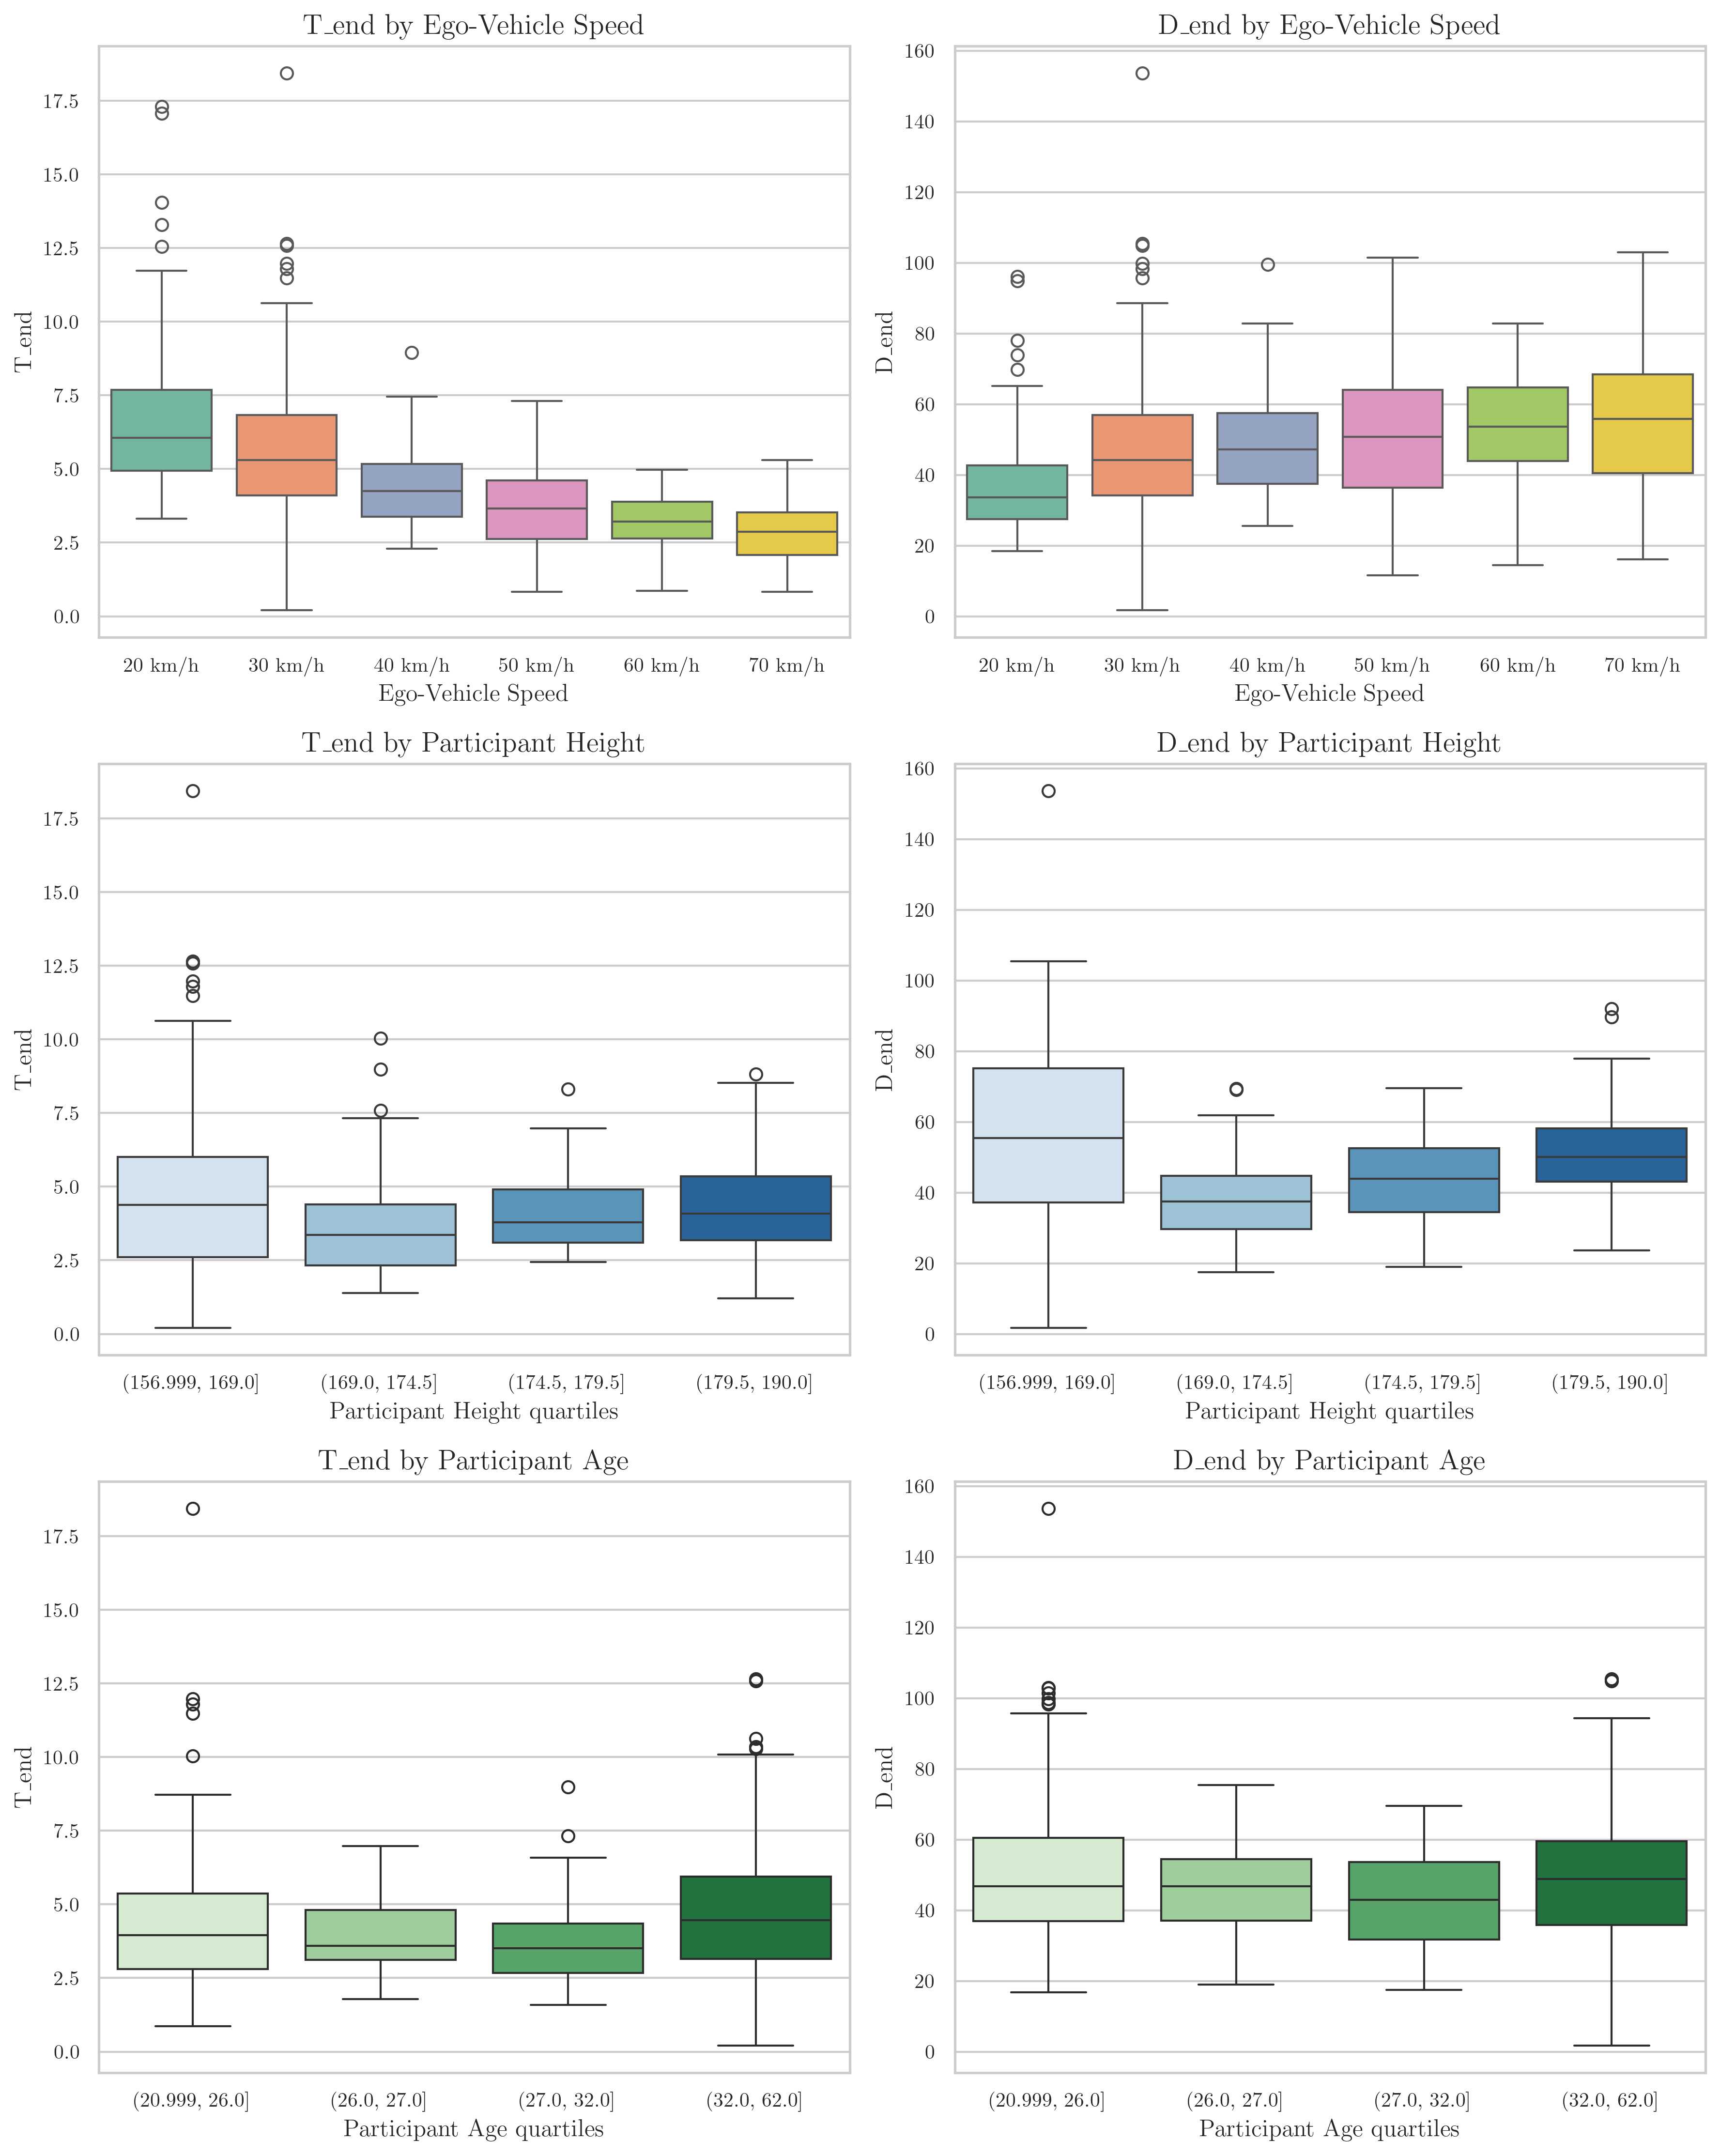

Polynomial model for T_end vs velocity_id: degree 1 with R² = 0.331
Residual normality (Shapiro p) = 0.000
→ Residuals non-normal, interpret with caution.
Polynomial model for D_end vs velocity_id: degree 1 with R² = 0.088
Residual normality (Shapiro p) = 0.000
→ Residuals non-normal, interpret with caution.
Polynomial model for T_end vs height: degree 2 with R² = 0.024
Residual normality (Shapiro p) = 0.000
→ Residuals non-normal, interpret with caution.
Polynomial model for D_end vs height: degree 2 with R² = 0.122
Residual normality (Shapiro p) = 0.000
→ Residuals non-normal, interpret with caution.
Polynomial model for T_end vs age: degree 1 with R² = 0.034
Residual normality (Shapiro p) = 0.000
→ Residuals non-normal, interpret with caution.
Polynomial model for D_end vs age: degree 1 with R² = 0.006
Residual normality (Shapiro p) = 0.000
→ Residuals non-normal, interpret with caution.


In [350]:
variables = ['T_end', 'D_end']
continuous_vars = ['velocity_id', 'height', 'age']

correlation_and_boxplots_grid_single_poly(df, variables, continuous_vars)


##  Analyse binaire – Effet du sexe & du permis sur les seuils de sécurité

Cette section introduit la fonction `compare_groups_grid`, dédiée à l’analyse de variables
**binaires / catégorielles à deux modalités**, ici :

- **sexe** : Man / Woman  
- **driver_license** : Yes / No  

L’objectif est d’examiner si l’un de ces facteurs individuels influence les deux variables
d’intérêt de l’expérience :

- **T_end** : Temps limite de sécurité
- **D_end** : Distance limite de sécurité


##  Contenu de l’analyse

### 1. **Statistiques descriptives**
Pour chaque groupe (ex : femmes vs hommes), la fonction affiche :

- moyenne  
- médiane  
- écart-type  
- min / max  
- taille de l’échantillon  

Cela permet de vérifier visuellement si une différence semble émerger.


### 2. **Tests statistiques (comparaison de deux groupes)**  
Lorsqu’il y a **deux groupes**, la fonction applique :

- **T-test** (si distributions plausibles normales)  
- **Mann–Whitney U test** (alternative non-paramétrique)

Ces tests indiquent si la différence observée entre les groupes est **statistiquement significative**.

Le script affiche les deux p-values pour une interprétation robuste.


### 3. **Visualisation avec boxplots**

Pour chaque variable (`T_end`, `D_end`) et pour chaque facteur (`sex`, `driver_license`) :

- un **boxplot** est généré,  
- les couleurs sont adaptées aux catégories (palettes définies en amont),  
- les valeurs manquantes ou déséquilibres de groupe sont gérés proprement.

Ces visualisations permettent de repérer :
- décalages de médianes,  
- asymétries,  
- dispersions différentes,  
- potentiels outliers.


##  4. Exécution sur les deux facteurs

La cellule suivante applique l’analyse :

```python
compare_groups_grid(
    df, 
    variables, 
    group_list=['sex', 'driver_license']
)
````

Cela produit une grille de 4 graphes :

| Variable dépendante | Facteur | Graphique       |
| ------------------- | ------- | --------------- |
| **T_end**           | sexe    | boxplot + stats |
| **T_end**           | permis  | boxplot + stats |
| **D_end**           | sexe    | boxplot + stats |
| **D_end**           | permis  | boxplot + stats |

Ainsi, cette étape permet de déterminer si des caractéristiques individuelles binaires influencent la prise de décision de traversée en VR, tant en distance qu’en temps.


In [351]:
def compare_groups_grid(df, vars_list, group_list, label_map=None, palette_map=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import ttest_ind, mannwhitneyu

    if label_map is None:
        label_map = {
            'sex': 'Participant Sex',
            'driver_license': 'Driver License Status',
            'T_end': 'T_end',
            'D_end': 'D_end'
        }

    if palette_map is None:
        palette_map = {
            'sex': {'Man': binary_palette['Man'], 'Woman': binary_palette['Woman']},
            'driver_license': {'No': binary_palette['0.0'], 'Yes': binary_palette['1.0']}
        }

    fig, axes = plt.subplots(len(group_list), len(vars_list), figsize=(6 * len(vars_list), 5 * len(group_list)))

    if len(group_list) == 1:
        axes = [axes]
    if len(vars_list) == 1:
        axes = [[ax] for ax in axes]

    for i, group in enumerate(group_list):
        for j, var in enumerate(vars_list):
            ax = axes[i][j]

            if group == 'driver_license':
                df['license_label'] = df['driver_license'].map({0.0: 'No', 1.0: 'Yes'})
                group_col = 'license_label'
            else:
                group_col = group

            print(f"\nComparison of {var} by {group}")
            print(df.groupby(group_col)[var].agg(['mean', 'std', 'median', 'min', 'max', 'count']))


            groups_data = [g[var].dropna() for name, g in df.groupby(group_col) if not g[var].dropna().empty]

            if len(groups_data) == 2:
                try:
                    stat_t, p_t = ttest_ind(*groups_data, equal_var=False)
                    stat_u, p_u = mannwhitneyu(*groups_data)
                    print(f"T-test p = {p_t:.3f} | Mann-Whitney p = {p_u:.3f}")
                except Exception as e:
                    print(f"Statistical test error: {e}")
            else:
                print("Not enough data for both groups to perform tests.")

            df_box = df[[group_col, var]].dropna()
            if not df_box.empty:
                present_labels = df_box[group_col].unique()
                pal_present = {k: v for k, v in palette_map[group].items() if k in present_labels}
                sns.boxplot(x=group_col, y=var, data=df_box, ax=ax, palette=pal_present)
                ax.set_xlabel(label_map.get(group, group))
                ax.set_title(f"{label_map.get(var, var)} by {label_map.get(group, group)}")
            else:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center')
                ax.set_axis_off()

    plt.tight_layout()
    plt.show()



Comparison of T_end by sex
           mean       std    median       min        max  count
sex                                                            
Man    4.095092  1.540935  3.832020  1.216368  10.034136    242
Woman  4.542679  2.520788  4.058729  0.197722  18.445080    188
T-test p = 0.033 | Mann-Whitney p = 0.359

Comparison of D_end by sex
            mean        std    median       min       max  count
sex                                                             
Man    46.460612  13.442424  46.01760  17.48180   92.0464    242
Woman  51.661237  23.632363  47.41105   1.64768  153.7090    188
T-test p = 0.007 | Mann-Whitney p = 0.175

Comparison of T_end by driver_license
                   mean       std    median       min        max  count
license_label                                                          
No             4.005301  1.694179  3.696659  1.384854  10.034136     54
Yes            4.331781  2.081382  3.921217  0.197722  18.445080    376
T-test p = 0.203 

C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3683919108.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_col, y=var, data=df_box, ax=ax, palette=pal_present)
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3683919108.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_col, y=var, data=df_box, ax=ax, palette=pal_present)
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3683919108.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_col, y=var, data=df_box, ax=ax, palette=pal_present)
C:\Users\svictor

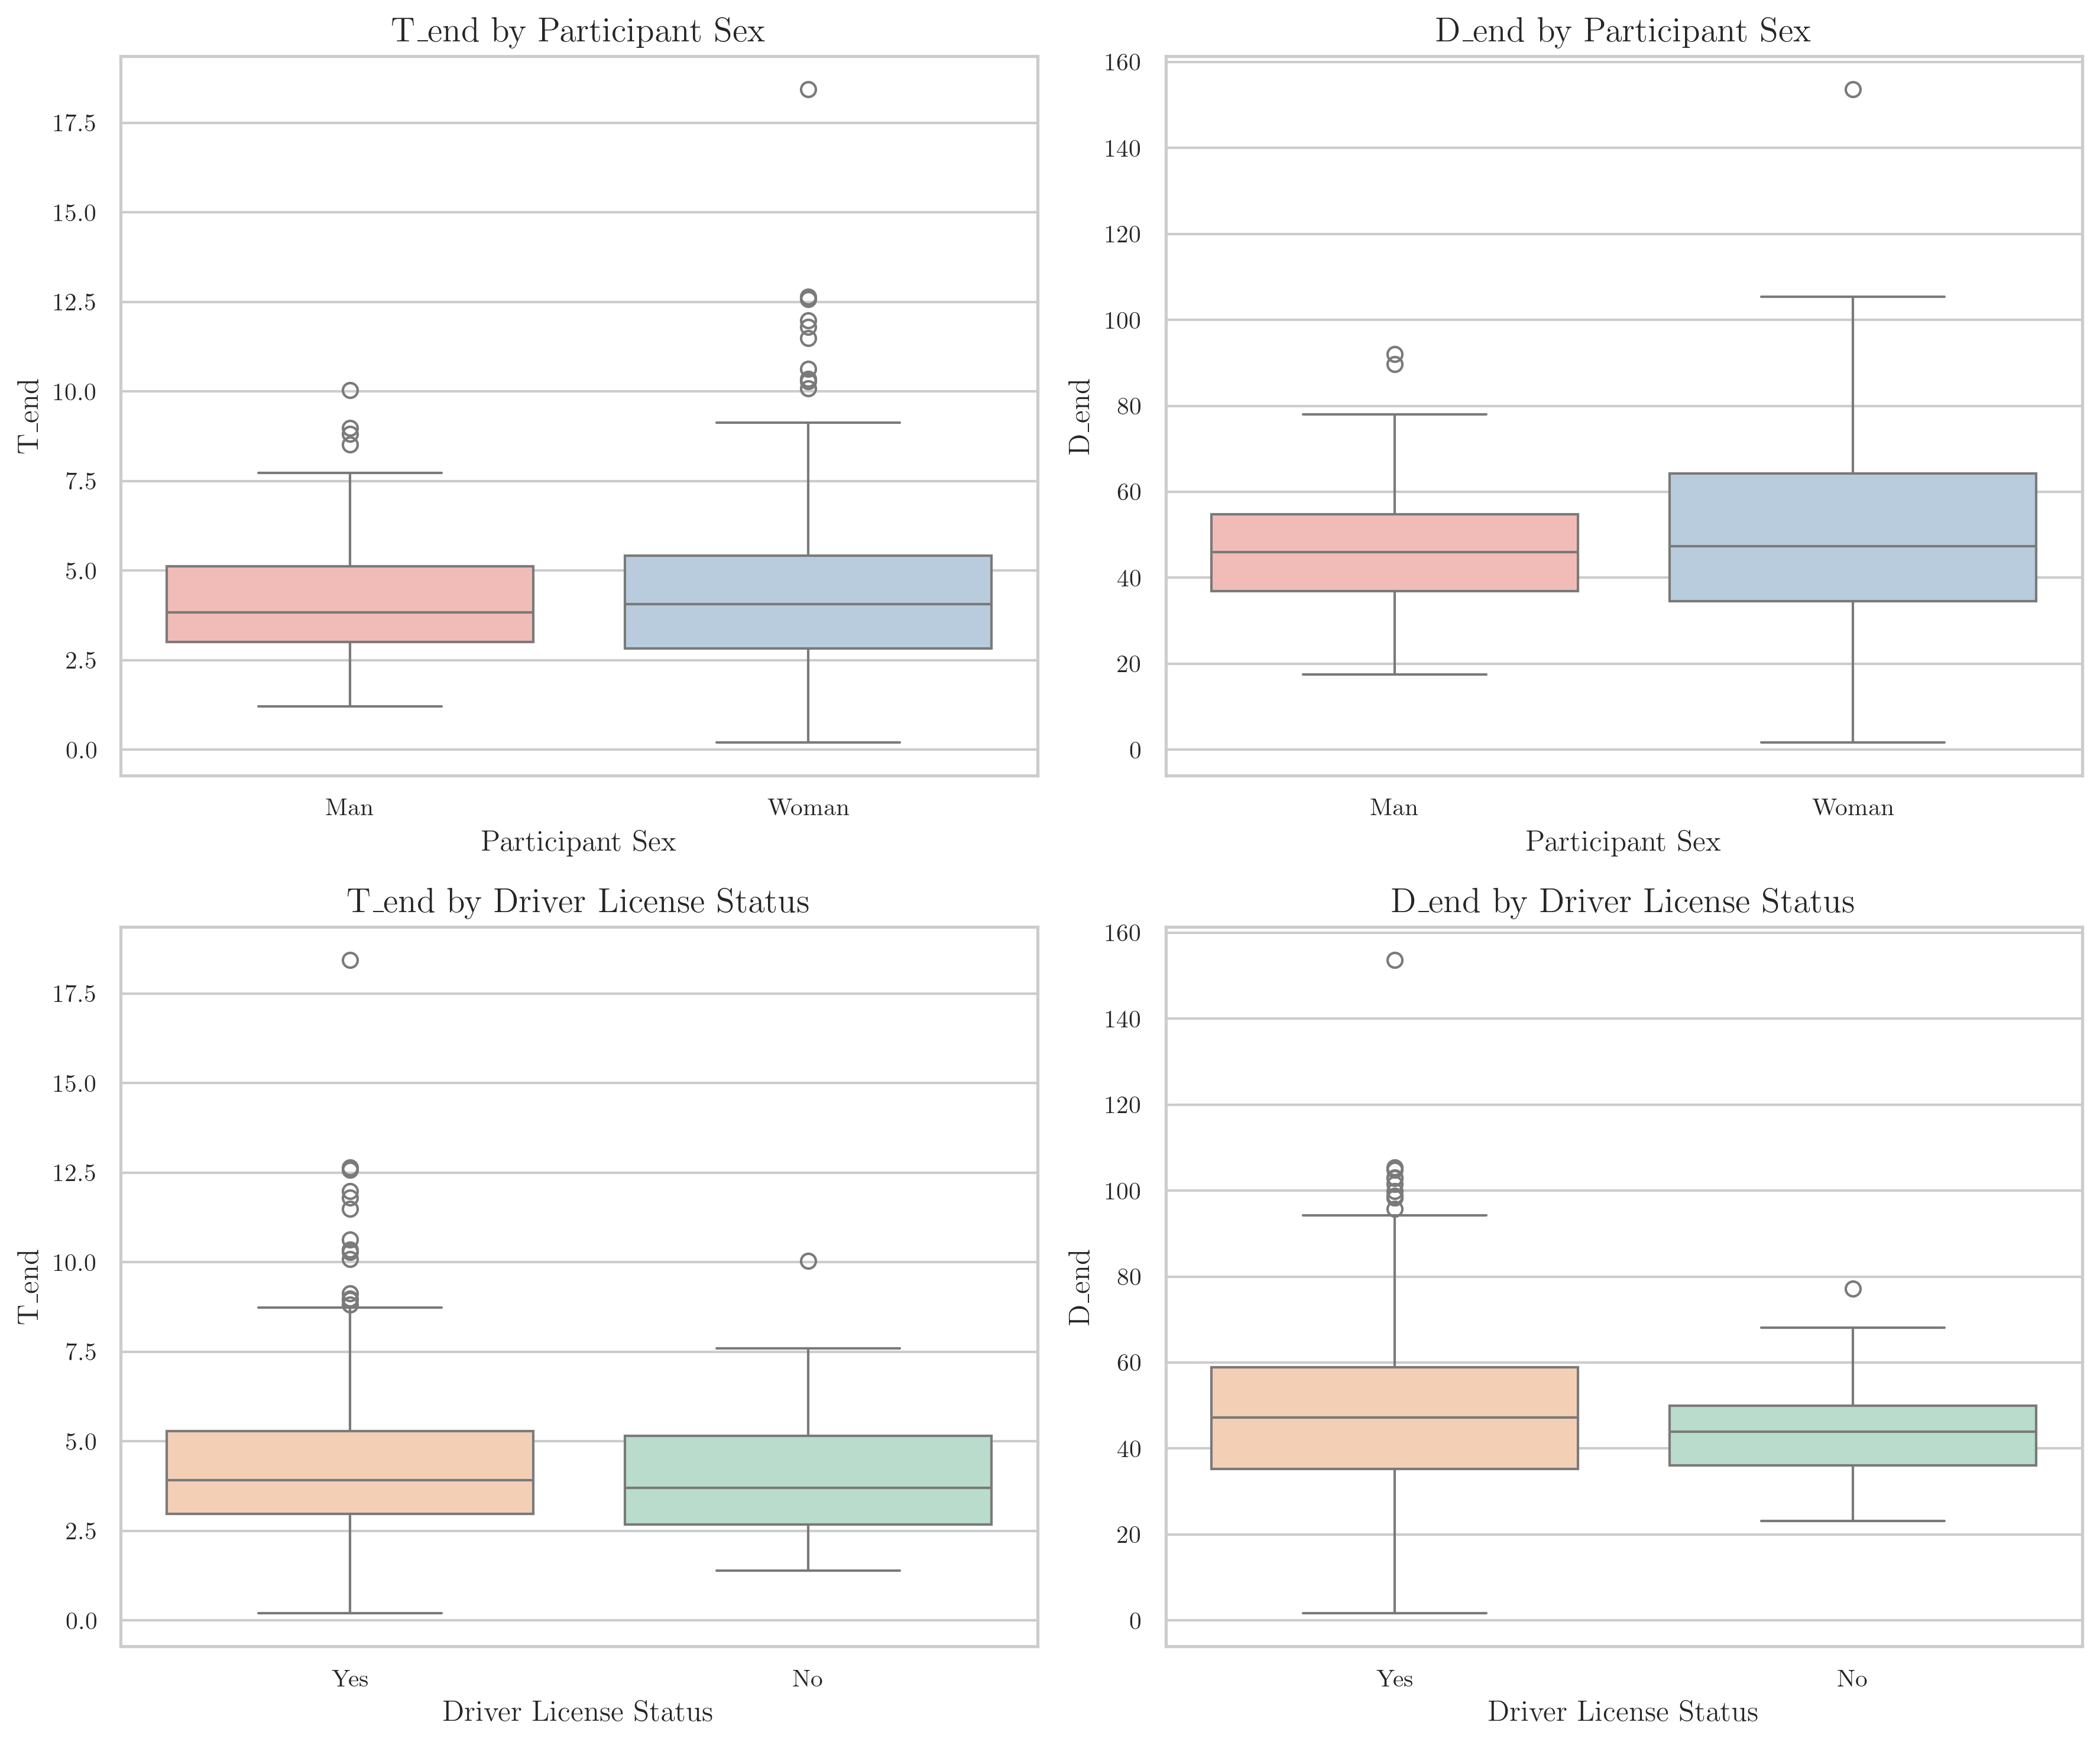

In [352]:
compare_groups_grid(
    df, 
    variables, 
    group_list=['sex', 'driver_license']
)



##  Analyse par variable catégorielle à plusieurs niveaux — Impact des conditions météo

Cette section étudie l’influence d’une variable catégorielle **à plus de deux modalités**  → `weather_id` : *clear*, *rain*, *night*

Contrairement aux variables binaires (sexe, permis), la variable météo comporte **trois niveaux**, ce qui nécessite l’usage de tests statistiques adaptés aux comparaisons multiples.

Nous analysons son effet sur :

- **T_end** : temps limite de sécurité  
- **D_end** : distance limite de sécurité  

Ces métriques représentent la décision de *non-crossing* d'un participant en fonction de l’approche du véhicule.


##  1. Statistiques descriptives par condition météo

La fonction `compare_conditions_compare` commence par afficher pour chaque condition météo :

- moyenne  
- écart-type  
- médiane  
- quartiles  
- effectif  

Cela permet de repérer rapidement si certaines conditions atmosphériques semblent associées à des distances ou temps de sécurité plus élevés.


##  2. Tests statistiques (comparaisons à 3 groupes)

Deux tests sont systématiquement réalisés :

###  **ANOVA à un facteur**  
→ valable si les groupes respectent l’hypothèse de normalité + homogénéité de variance.

###  **Kruskal–Wallis**  
→ alternative **non-paramétrique**, plus robuste en cas de distributions non normales.

Le script affiche :  

- la p-value ANOVA  
- la p-value Kruskal–Wallis  

Si une p-value < 0.05 → les différences entre conditions météo sont statistiquement significatives.  
Le *post-hoc* n’est pas inclus ici, mais il pourrait être ajouté via Dunn (comme pour l’Exp1).


##  3. Visualisation : Boxplots par condition météo

Pour chaque variable (`T_end`, `D_end`), la fonction produit un **boxplot** où :

- chaque boîte correspond à *clear*, *rain* ou *night*  
- les couleurs proviennent de `weather_palette`  
- les médianes et étendues des valeurs sont immédiatement visibles  

Ces graphes permettent d'interpréter visuellement l’effet du climat sur les décisions de traversée.


##  4. Exécution sur `weather_id`

La boucle suivante applique automatiquement l’analyse :

```python
for cat in multi_cats:
    pal = None
    if cat == 'weather_id':
        pal = weather_palette
    compare_conditions_compare(df, variables, cat, palette=pal)
````

Elle génère :

* **2 boxplots** (T_end et D_end × météo)
* statistiques descriptives
* p-values ANOVA et Kruskal–Wallis


##  Intérêt pour l’étude

Cette étape permet de vérifier si les conditions météorologiques :

* modifient la perception du danger,
* influencent le seuil temporel/distance auquel le participant renonce à traverser,
* introduisent une variabilité comportementale utile pour la modélisation robuste.



In [353]:
def compare_conditions_compare(df, vars_list, condition, palette=None):
    n = len(vars_list)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1:
        axes = [axes]

    for ax, var in zip(axes, vars_list):
        print(f"\nAnalysis of {var} by {condition}")
        print(df.groupby(condition)[var].describe())

        groups = [g[var].dropna() for name, g in df.groupby(condition)]
        stat_a, p_a = f_oneway(*groups)
        stat_k, p_k = kruskal(*groups)
        print(f"ANOVA p = {p_a:.3f} | Kruskal-Wallis p = {p_k:.3f}")

        sns.boxplot(x=condition, y=var, data=df, ax=ax, palette=palette)
        ax.set_title(f"{var} by Weather Condition")  # Custom title
        ax.set_xlabel('Weather Condition')           # Custom x-label

    plt.tight_layout()
    plt.show()



Analysis of T_end by weather_id
            count      mean       std       min       25%       50%       75%  \
weather_id                                                                      
clear       171.0  4.407643  1.980010  0.197722  3.081126  4.083813  5.401767   
night       169.0  4.744158  2.863302  0.835855  2.955555  3.987319  5.710752   
rain        170.0  4.321784  2.122412  0.825567  2.951619  3.964860  5.056847   

                  max  
weather_id             
clear       12.562938  
night       18.445080  
rain        14.045454  
ANOVA p = 0.218 | Kruskal-Wallis p = 0.618

Analysis of D_end by weather_id
            count       mean        std       min        25%      50%  \
weather_id                                                              
clear       171.0  49.509696  18.564131   1.64768  35.212950  47.8757   
night       169.0  50.596551  20.460450  11.60910  36.908000  47.2375   
rain        170.0  47.788214  18.222246  16.05270  33.504425  45.2873   


C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\4231223466.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=condition, y=var, data=df, ax=ax, palette=palette)
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\4231223466.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=condition, y=var, data=df, ax=ax, palette=palette)


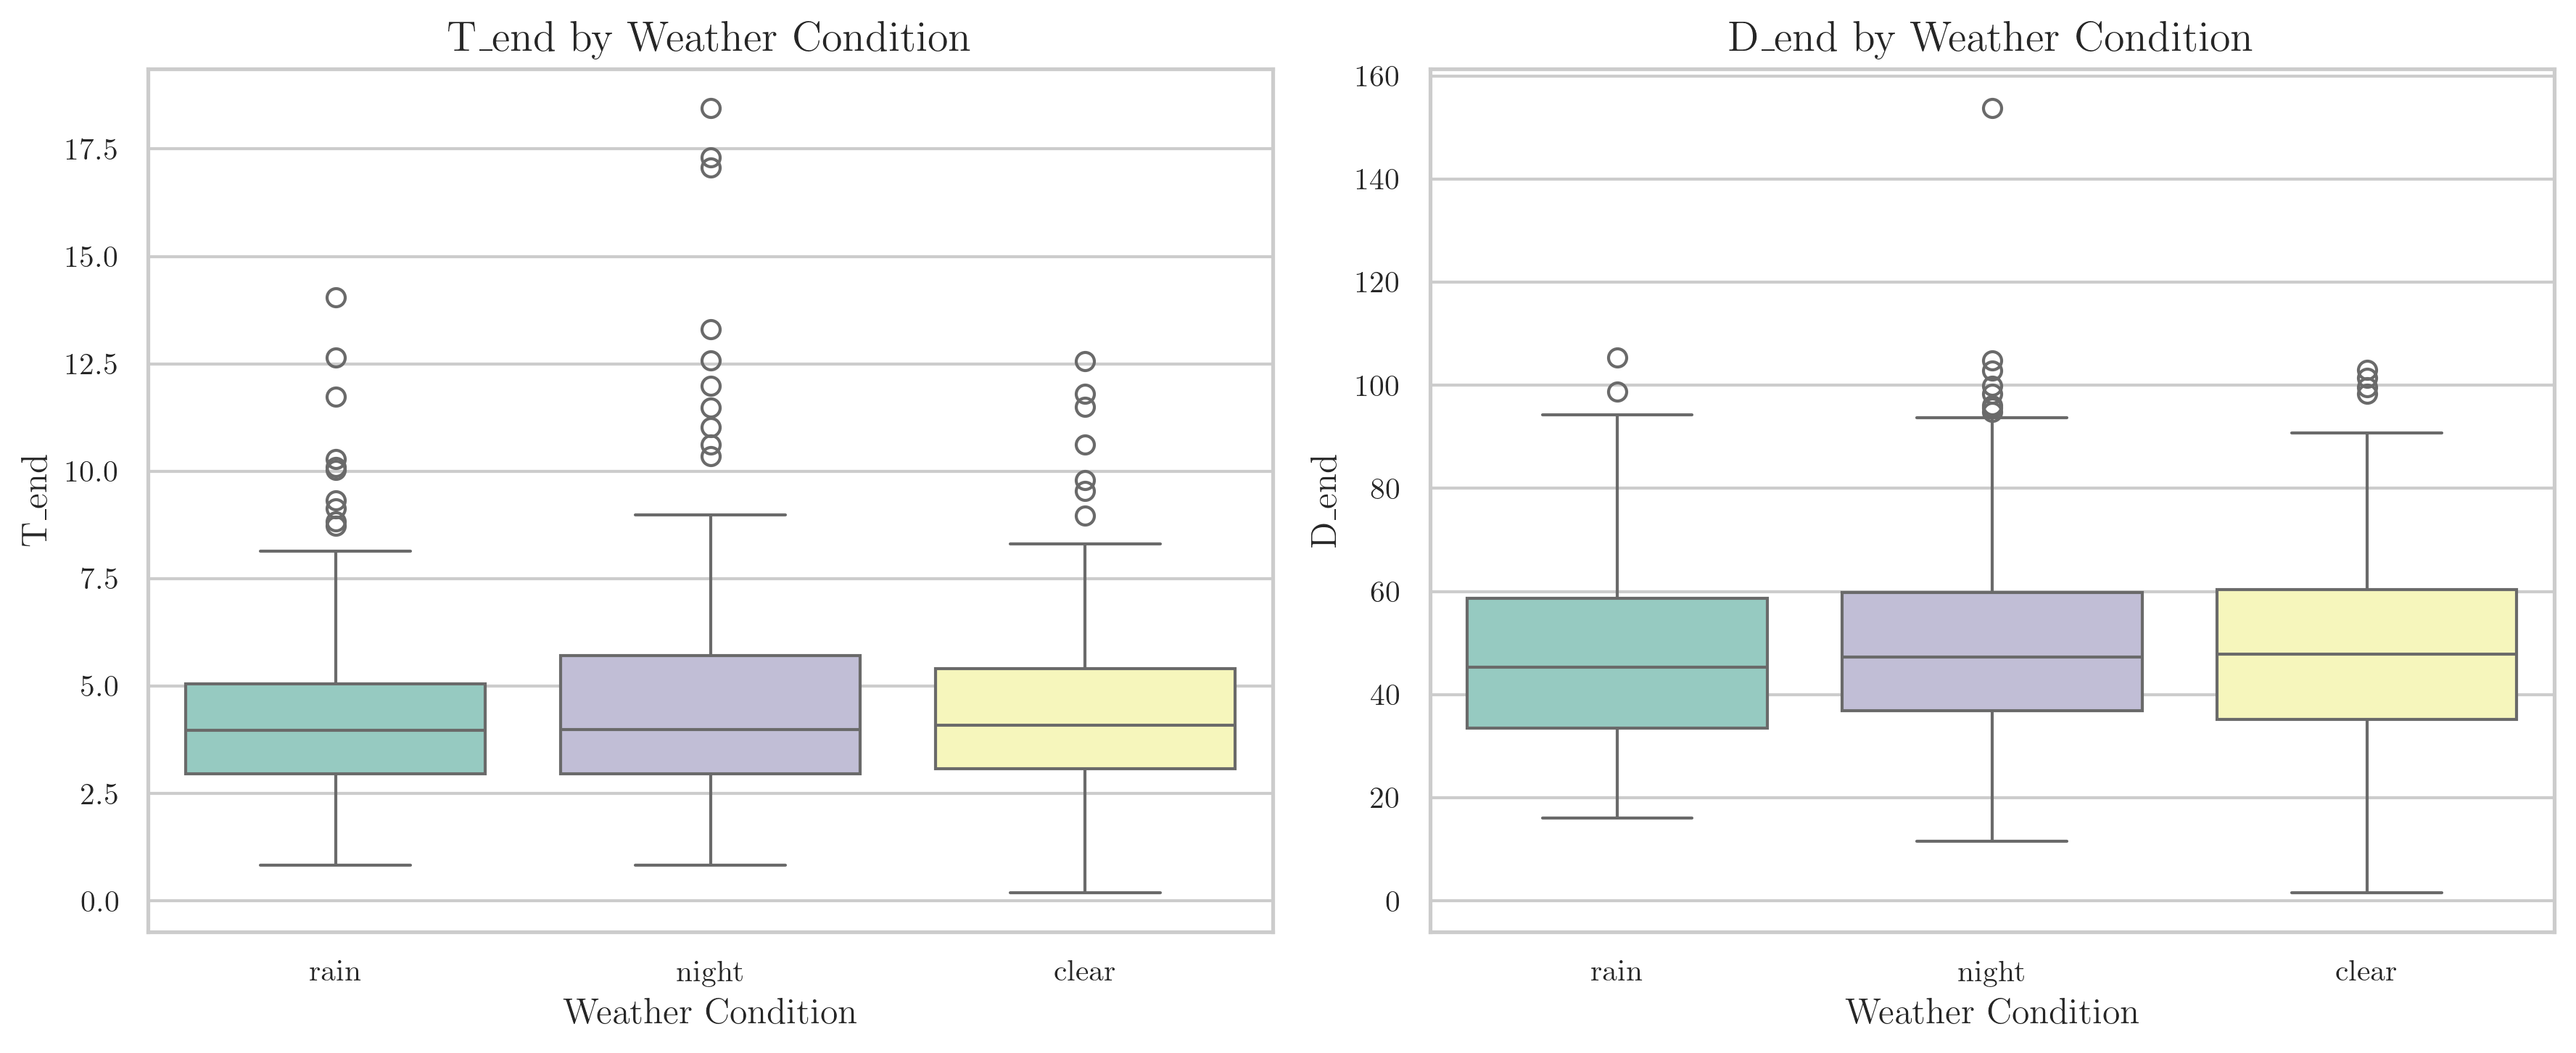

In [354]:
for cat in multi_cats:
    pal = None
    if cat == 'weather_id':
        pal = weather_palette
    compare_conditions_compare(df, variables, cat, palette=pal)

##  Analyse continue : effet de la vitesse selon la météo (LOWESS)

Cette section vise à explorer **l’interaction entre la vitesse du véhicule et les conditions météo** sur les seuils de sécurité mesurés dans l’Expérience 2 :

- **T_end** : temps limite avant non-traversée  
- **D_end** : distance limite avant non-traversée  

L’objectif est d’observer comment ces seuils évoluent **en fonction de la vitesse du véhicule**, et comment cette relation diffère entre les conditions météo :

- *clear*
- *rain*
- *night*


##  Pourquoi LOWESS ?

Le lissage **LOWESS (Locally Weighted Scatterplot Smoothing)** permet de :

- capturer des tendances **non linéaires** entre vitesse et T_end/D_end,  
- éviter les hypothèses paramétriques strictes,  
- visualiser la *structure comportementale réelle* des participants.  

C’est particulièrement pertinent ici car la relation vitesse → seuil de sécurité peut être :

- non-linéaire,  
- différente d’un contexte météo à l’autre,  
- influencée par des comportements humains variables.


##  Ce que fait la fonction `plot_lowess_by_weather`

### 1. Deux visualisations côte à côte  
- **Graphique gauche** : relation *vitesse → T_end*  
- **Graphique droit** : relation *vitesse → D_end*

Chaque graphique contient :
- les **points individuels** (scatter)  
- un **lissage LOWESS** par condition météo  
- un codage couleur via `weather_palette`


##  2. Lecture des résultats attendus

Ces graphes permettent de répondre à plusieurs questions clés :

###  *Les participants sont-ils plus prudents sous la pluie ?*  
→ T_end ou D_end plus élevés pour *rain* par rapport à *clear*.

###  *La nuit augmente-t-elle le seuil de sécurité ?*  
→ courbes LOWESS plus hautes pour *night*.

###  *La vitesse modifie-t-elle différemment le seuil selon la météo ?*  
→ ≠ formes de courbe selon la météo  
(ex : saturation à haute vitesse, effet non linéaire, etc.)

Cette analyse est un **complément essentiel** aux analyses par groupes, car elle révèle des tendances subtiles non visibles avec des boxplots.


##  3. Exécution

La commande suivante génère les deux graphes :

```python
plot_lowess_by_weather(df, weather_palette)
````

Elle produit une figure claire, avec une légende commune à droite, facilitant la comparaison directe entre conditions météo.


##  Intérêt pour la modélisation

Ces tendances permettent :

* de comprendre **comment la météo module la perception du danger**,
* d'inspirer la structure des features pour le modèle final,
* de valider que la météo a bien un **effet comportemental continu**,
* d’identifier des zones où un modèle linéaire serait insuffisant.



In [355]:
def plot_lowess_by_weather(df, weather_palette):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    # T_end plot (left)
    sns.scatterplot(
        data=df,
        x='velocity_id', y='T_end',
        hue='weather_id',
        palette=weather_palette,
        ax=axes[0],
        legend=False,
        alpha=0.6,
        edgecolor=None,
    )
    for weather, color in weather_palette.items():
        subset = df[df['weather_id'] == weather]
        sns.regplot(
            data=subset,
            x='velocity_id', y='T_end',
            scatter=False,
            lowess=True,
            ax=axes[0],
            color=color,
            label=weather
        )
    axes[0].set_title("T_end by Ego-Vehicle Speed, by Weather Condition")
    axes[0].set_xlabel("Ego-Vehicle Speed")
    axes[0].set_ylabel("T_end")
    if axes[0].legend_ is not None:
        axes[0].legend_.remove()

    # D_end plot (right)
    sns.scatterplot(
        data=df,
        x='velocity_id', y='D_end',
        hue='weather_id',
        palette=weather_palette,
        ax=axes[1],
        legend=False,
        alpha=0.6,
        edgecolor=None,
    )
    for weather, color in weather_palette.items():
        subset = df[df['weather_id'] == weather]
        sns.regplot(
            data=subset,
            x='velocity_id', y='D_end',
            scatter=False,
            lowess=True,
            ax=axes[1],
            color=color,
            label=weather
        )
    axes[1].set_title("D_end by Ego-Vehicle Speed, by Weather Condition")
    axes[1].set_xlabel("Ego-Vehicle Speed")
    axes[1].set_ylabel("D_end")
    if axes[1].legend_ is not None:
        axes[1].legend_.remove()

    # Légende commune plus proche, à droite
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, title="Weather Condition", loc='upper right')

    plt.tight_layout(rect=[0, 0, 0.95, 1])
    plt.show()


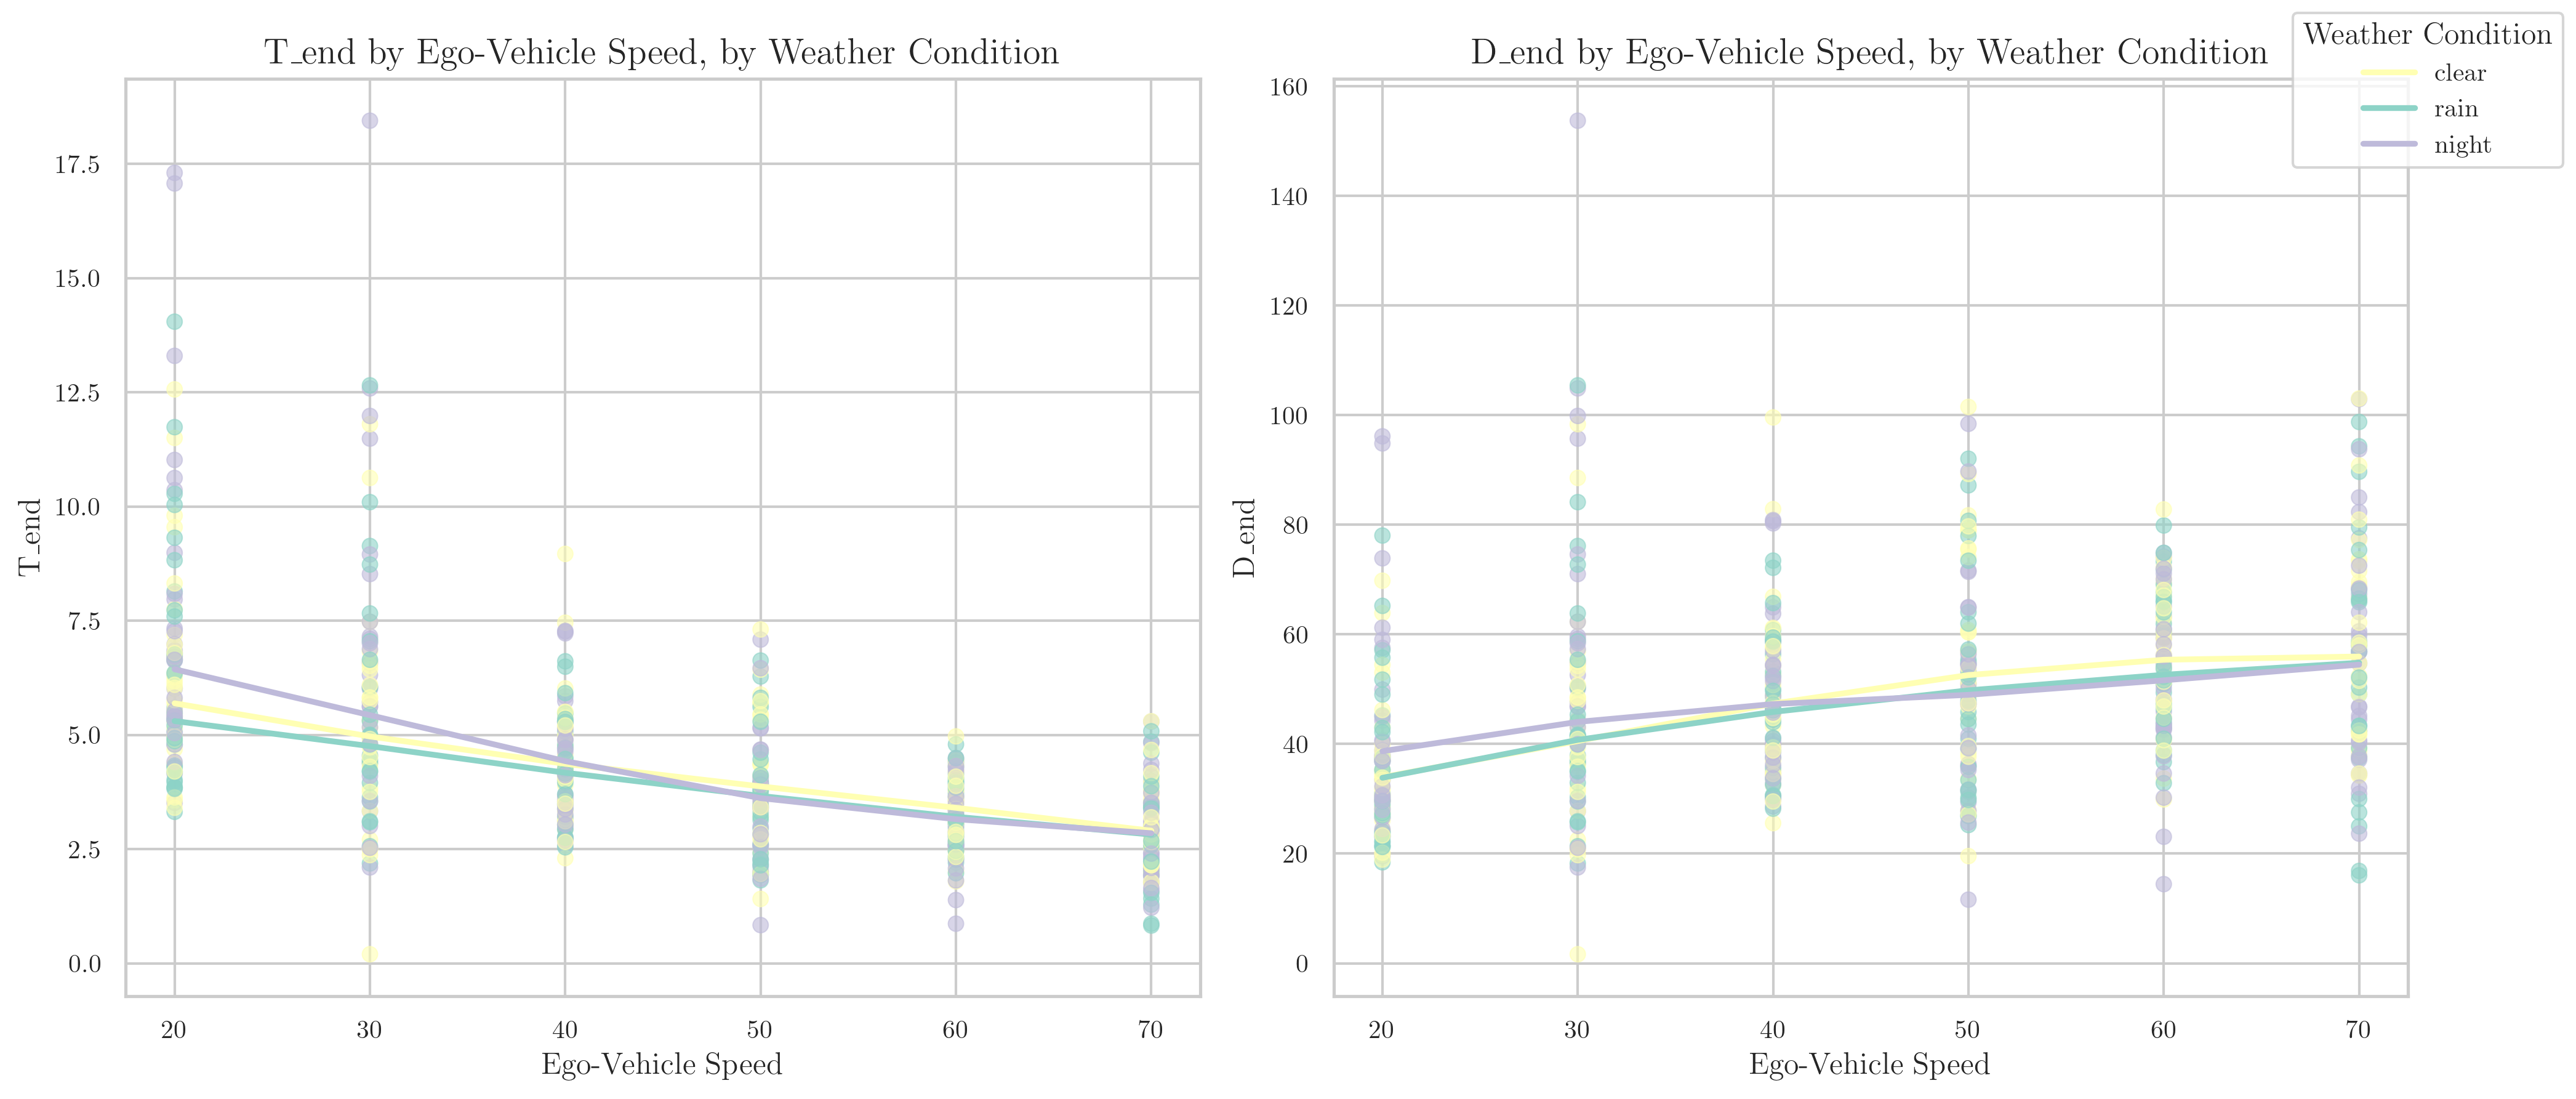

In [356]:
plot_lowess_by_weather(df, weather_palette)

##  Influence de la taille des participants selon la météo

Dans cette section, nous examinons **comment la hauteur des participants influence le seuil de sécurité** :

- **T_end** : temps limite avant collision  
- **D_end** : distance limite avant collision  

et surtout comment cette relation varie **en fonction de la météo** (*clear*, *rain*, *night*).

L’objectif est d’observer si les personnes plus grandes adoptent un comportement plus prudent (ou inversement), et si la météo modère cet effet.


##  Pourquoi un modèle polynomial (ordre 2) ?

L’effet de la taille sur le comportement peut être :

- légèrement **courbé** (non linéaire),  
- sujet à des comportements différents aux extrêmes de la distribution,  
- influencé par la perception visuelle (hauteur → champ visuel → prise de décision).

Un polynôme de degré 2 (**quadratique**) est souvent suffisant pour capturer :

- une tendance croissante puis stabilisée,  
- une relation convexe/concave,  
- des asymétries perceptives.


##  Ce que fait la fonction `plot_poly_by_weather_height`

Elle génère **deux figures côte à côte** :

### 1. T_end ~ Height  
Scatter + ajustement polynomial (ordre 2) **séparé pour chaque météo**.

Permet de déterminer si :  
- les personnes plus grandes laissent plus ou moins de marge temporelle,  
- la météo amplifie ou réduit cet effet.

### 2. D_end ~ Height  
Même principe, mais sur la distance limite plutôt que le temps.


##  Lecture possible des résultats

Ces graphiques permettent d'évaluer :

###  Effet perceptif lié à la taille  
Un piéton plus grand peut percevoir la scène différemment (vision plus haute, horizon dégagé).

###  Interaction taille × météo  
Par exemple :  
- Sous la pluie : courbes potentiellement **plus hautes** → comportement plus prudent.  
- La nuit : courbes possiblement **plus aplaties** → difficulté accrue à estimer les distances.

###  Non-linéarité  
Si la courbe montre une forme "U" ou "plateau", cela indique que l’effet de la taille n’est pas constant.


##  Exécution

La commande suivante génère les deux visualisations :

```python
plot_poly_by_weather_height(df, weather_palette)
````

Avec une légende commune regroupée dans le coin supérieur droit.

##  Intérêt pour le modèle comportemental

Cette analyse est utile pour :

* enrichir les **features physiologiques** (ex : height-normalized distances),
* vérifier si **la taille influence différemment les scénarios météo**,
* alimenter la section discussion de la thèse (**différences individuelles**),
* valider ou non l’intégration de l’interaction *height × weather* dans les modèles finaux.



In [357]:
def plot_poly_by_weather_height(df, weather_palette):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    # T_end plot (left)
    sns.scatterplot(
        data=df,
        x='height', y='T_end',
        hue='weather_id',
        palette=weather_palette,
        ax=axes[0],
        legend=False,
        alpha=0.6,
        edgecolor=None,
    )
    for weather, color in weather_palette.items():
        subset = df[df['weather_id'] == weather]
        sns.regplot(
            data=subset,
            x='height', y='T_end',
            scatter=False,
            order=2,  # polynôme degré 2
            ax=axes[0],
            color=color,
            label=weather
        )
    axes[0].set_title("T_end as a function of Participant Height, stratified by Weather Condition")
    axes[0].set_xlabel("Participant Height")
    axes[0].set_ylabel("T_end")
    if axes[0].legend_ is not None:
        axes[0].legend_.remove()

    # D_end plot (right)
    sns.scatterplot(
        data=df,
        x='height', y='D_end',
        hue='weather_id',
        palette=weather_palette,
        ax=axes[1],
        legend=False,
        alpha=0.6,
        edgecolor=None,
    )
    for weather, color in weather_palette.items():
        subset = df[df['weather_id'] == weather]
        sns.regplot(
            data=subset,
            x='height', y='D_end',
            scatter=False,
            order=2,
            ax=axes[1],
            color=color,
            label=weather
        )
    axes[1].set_title("D_end as a function of Participant Height, stratified by Weather Condition")
    axes[1].set_xlabel("Participant Height")
    axes[1].set_ylabel("D_end")
    if axes[1].legend_ is not None:
        axes[1].legend_.remove()

    # Légende commune en haut à droite
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, title="Weather Condition", loc='upper right')

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # ajuste pour faire de la place à la légende
    plt.show()


In [358]:
plot_poly_by_weather_height(df, weather_palette)

##  Analyse croisée de deux facteurs (T_end & D_end)

Certaines influences sur le comportement de traversée ne sont visibles **que lorsqu’on examine deux facteurs simultanément**.  
Exemples typiques :  
- *Sexe × Météo*  
- *Age × Météo*  
- *Taille × Vitesse*  
- *Permis × Météo*  

Cette cellule explore précisément ces interactions via un **“crossed mean barplot”**, permettant de visualiser la moyenne de `T_end` et `D_end` pour **toutes les combinaisons** de deux variables catégorielles ou discrétisées.


##  Objectif de la fonction `mean_cross_table()`

Elle sert à :

1. **Croiser deux variables explicatives**  
   (ex : `sex` et `weather_id`)

2. **Calculer les moyennes** pour :  
   - la distance limite (`D_end`)  
   - le temps limite (`T_end`)  

3. **Discrétiser automatiquement** les variables continues si nécessaire :  
   - `age` → quartiles `Age_bin`  
   - `height` → quartiles `Height_bin`  
   - `velocity_id` → catégories `"20 km/h" …`

4. **Normaliser les labels** et **harmoniser les palettes** selon la variable.

5. **Afficher un barplot croisé** :  
   - axe X : première variable catégorisée  
   - couleur : seconde variable  
   - hauteur : moyenne de `T_end` ou `D_end`

6. **Afficher un tableau pivot textuel** (console) pour vérification.


##  Variables croisées automatiquement

La boucle :

```python
for (cat1, cat2) in crosses:
    ...
    mean_cross_table(df, variables, cat1, cat2, ...)
````

génère toutes les combinaisons intéressantes :

### Catégorielle × Catégorielle

* météo × sexe
* météo × permis
* sexe × permis

### Catégorielle × Continue (discrétisée automatiquement)

* météo × vitesse
* météo × taille
* météo × âge
* sexe × vitesse
* etc.

### Continue × Continue (discrétisées toutes les deux)

* vitesse × taille
* vitesse × âge
* taille × âge

Cela offre une **vision exhaustive des interactions potentielles**.


##  Que montre exactement le graphique ?

Pour chaque paire `(cat1, cat2)` et chaque variable dépendante (`T_end`, `D_end`) :

* L’axe horizontal montre les niveaux (cat1)
* Chaque barre représente la **moyenne** du comportement
* Les couleurs correspondent aux niveaux de (cat2)
* Une palette cohérente est automatiquement appliquée :

  * météo → `weather_palette`
  * sexe → `binary_palette`
  * vitesse → `velocity_palette`
  * âge → `age_palette`
  * taille → `height_palette`

Cela permet par exemple de voir si :

###  Les femmes sont plus prudentes sous la pluie

###  Les conducteurs laissent un D_end plus élevé la nuit

###  Les tranches d’âge extrêmes réagissent différemment selon la météo

###  La taille augmente ou diminue T_end selon la vitesse du véhicule

Ces interactions sont importantes en modélisation comportementale.


##  Utilité scientifique

Cette analyse :

* permet de **détecter des interactions non linéaires**,
* met en évidence des effets combinés (ex : *“les effets du sexe ne sont visibles que sous certaines conditions météo”*),
* oriente la construction de modèles explicatifs (features d’interaction),
* sert de base pour la discussion des *individual differences* dans ta thèse.


##  Exécution

La boucle suivante génère automatiquement **toutes les analyses croisées** :

```python
for (cat1, cat2) in crosses:
    ...
    mean_cross_table(df, variables, cat1, cat2, palette_cat1=pal1, palette_cat2=pal2)
```




In [359]:
def mean_cross_table(df, vars_list, cat1, cat2, palette_cat1=None, palette_cat2=None):
    def format_interval(interval):
        return f"{int(interval.left)}–{int(interval.right)}"

    def prettify_col(col_name, col_data):
        if col_name in ['Age_bin', 'Height_bin']:
            return col_data.apply(format_interval)
        elif col_name == 'velocity_cat':
            return col_data.astype(str)  # <-- ici, PAS de + " km/h"
        else:
            return col_data.astype(str)

    def prettify_palette(col_name, col_data, palette):
        if palette is None:
            return None
        unique_cats = sorted(col_data.unique())
        if col_name == 'velocity_cat':
            return {f"{int(k)} km/h": v for k, v in velocity_palette.items() if f"{int(k)} km/h" in unique_cats}
        elif col_name in ['Age_bin', 'Height_bin']:
            return {format_interval(k): v for k, v in palette.items() if format_interval(k) in unique_cats}
        else:
            return {str(k): v for k, v in palette.items() if str(k) in unique_cats}

    def bin_column(df, col):
        if col == 'age' and 'Age_bin' in df.columns:
            return 'Age_bin'
        elif col == 'height' and 'Height_bin' in df.columns:
            return 'Height_bin'
        elif col == 'velocity_id':
            return 'velocity_cat'
        else:
            return col

    binned_cat1 = bin_column(df, cat1)
    binned_cat2 = bin_column(df, cat2)

    n = len(vars_list)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1:
        axes = [axes]

    for ax, var in zip(axes, vars_list):
        print(f"\nCrossed barplot of mean {var} by {cat1} and {cat2}")

        pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
        print(pivot)

        df_long = pivot.melt(id_vars=binned_cat1, value_name=var, var_name=binned_cat2)

        df_long[binned_cat1] = prettify_col(binned_cat1, df_long[binned_cat1])
        df_long[binned_cat2] = prettify_col(binned_cat2, df_long[binned_cat2])

        palette_cat2_final = prettify_palette(binned_cat2, df_long[binned_cat2], palette_cat2)
        palette_to_use = palette_cat2_final if palette_cat2_final is not None else "Set2"

        sns.barplot(data=df_long, x=binned_cat1, y=var, hue=binned_cat2, palette=palette_to_use, ax=ax)
        ax.set_title(f"Mean {var} by {cat1} and {cat2}")
        ax.set_xlabel(cat1)
        ax.set_ylabel(f"Mean {var}")

    plt.tight_layout()
    plt.show()



Crossed barplot of mean T_end by weather_id and sex
sex weather_id       Man     Woman
0        clear  4.167902  4.252700
1        night  4.096545  4.995981
2         rain  4.019901  4.386552

Crossed barplot of mean D_end by weather_id and sex
sex weather_id        Man      Woman
0        clear  48.101025  49.911331
1        night  45.349832  55.324768
2         rain  45.924357  49.805763



Crossed barplot of mean T_end by weather_id and driver_license
driver_license weather_id       0.0       1.0
0                   clear  4.043579  4.228062
1                   night  3.808752  4.584108
2                    rain  4.163571  4.184005

Crossed barplot of mean D_end by weather_id and driver_license
driver_license weather_id        0.0        1.0
0                   clear  46.055744  49.298361
1                   night  40.591528  50.982596
2                    rain  44.830489  48.038103


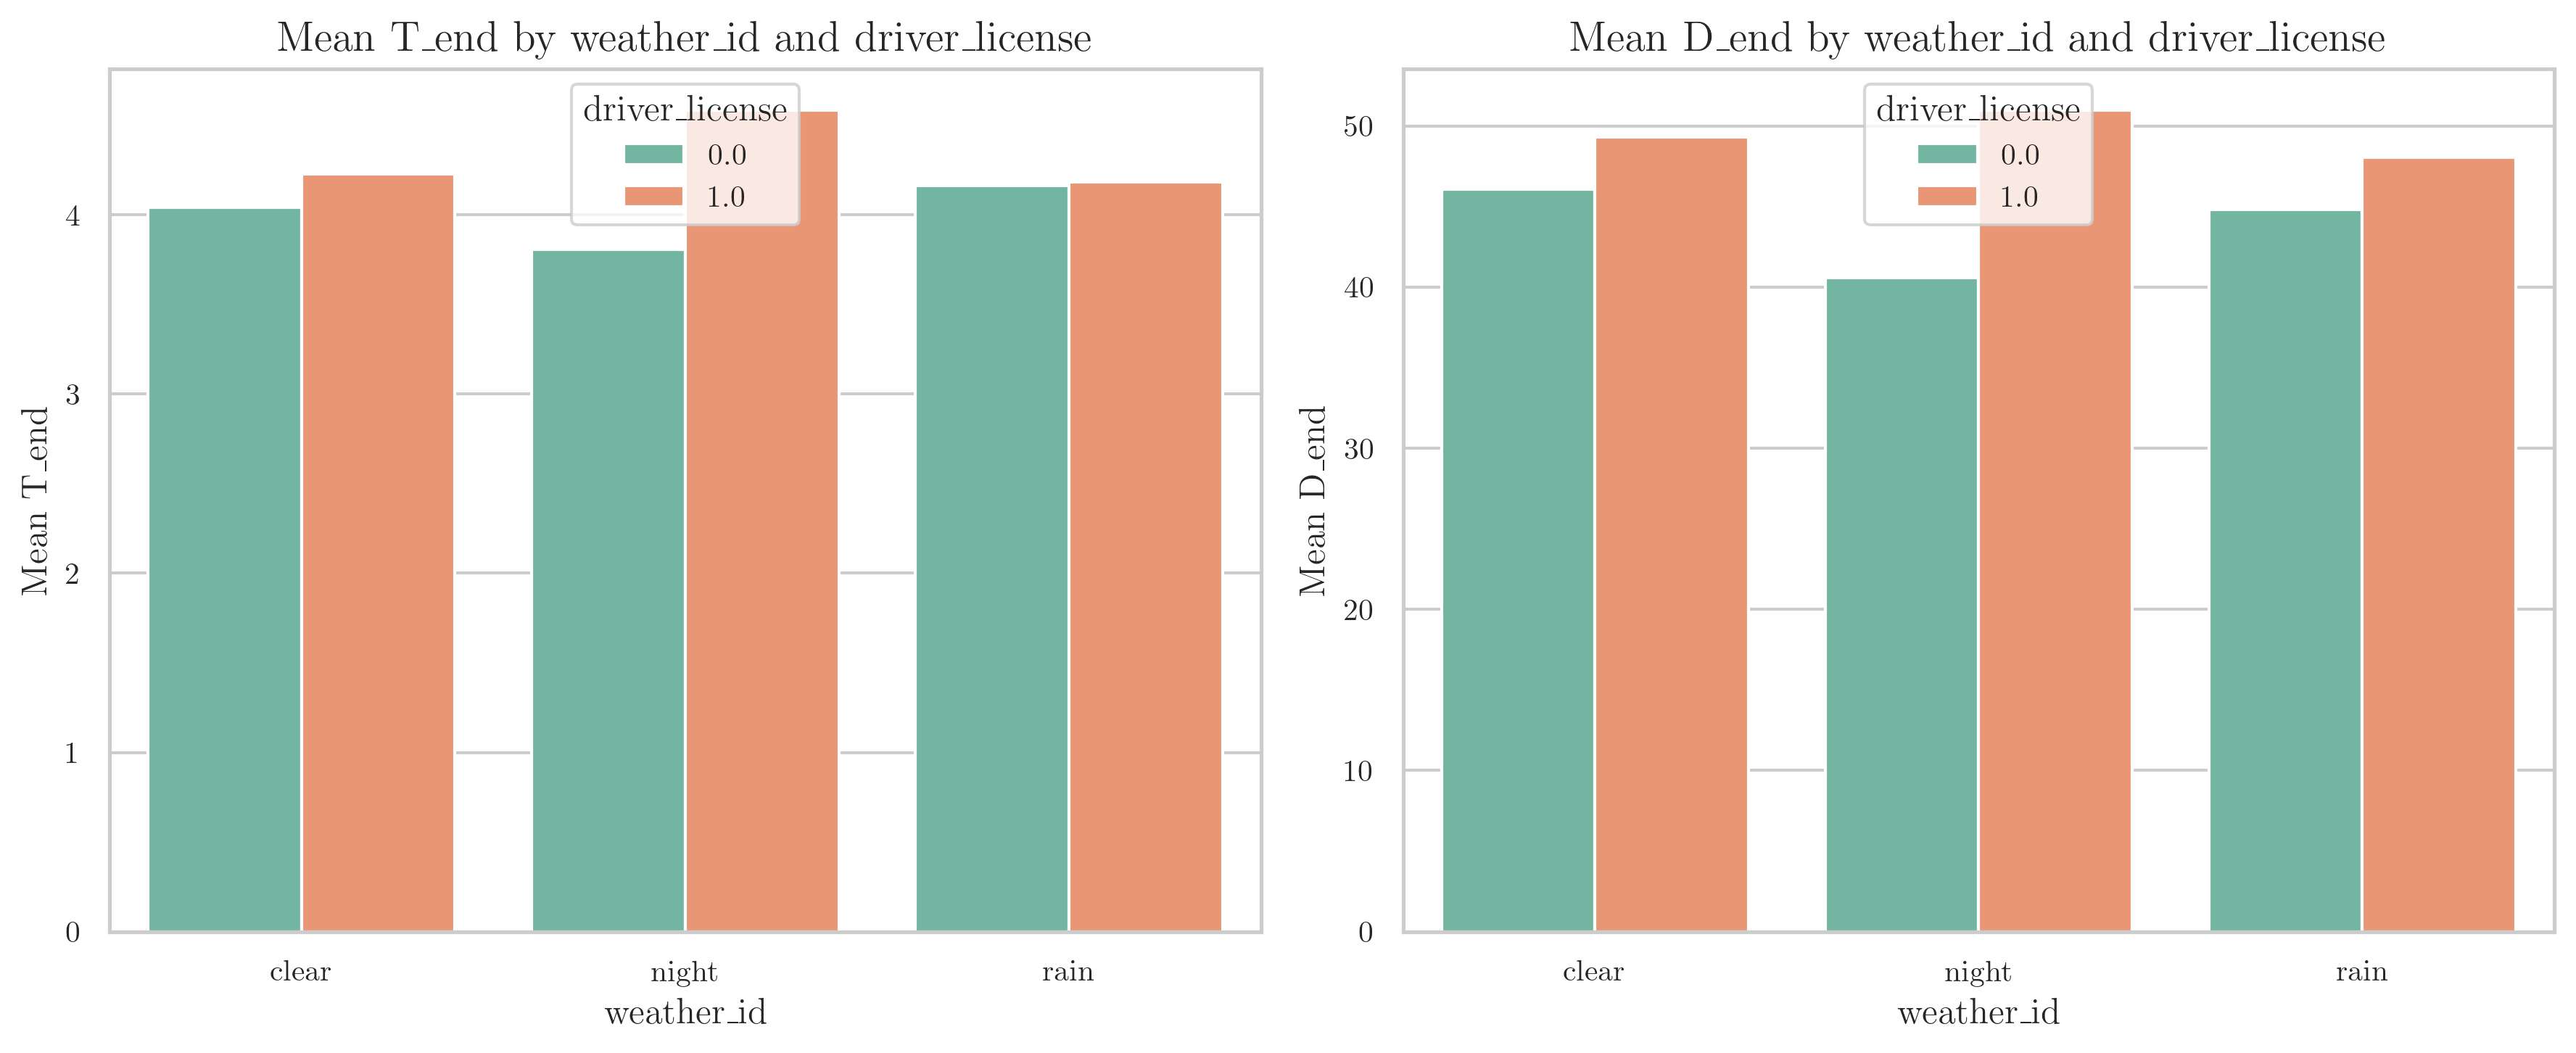


Crossed barplot of mean T_end by sex and driver_license
driver_license    sex       0.0       1.0
0                 Man  4.005301  4.120883
1               Woman       NaN  4.542679

Crossed barplot of mean D_end by sex and driver_license
driver_license    sex       0.0        1.0
0                 Man  43.82592  47.217385
1               Woman       NaN  51.661237


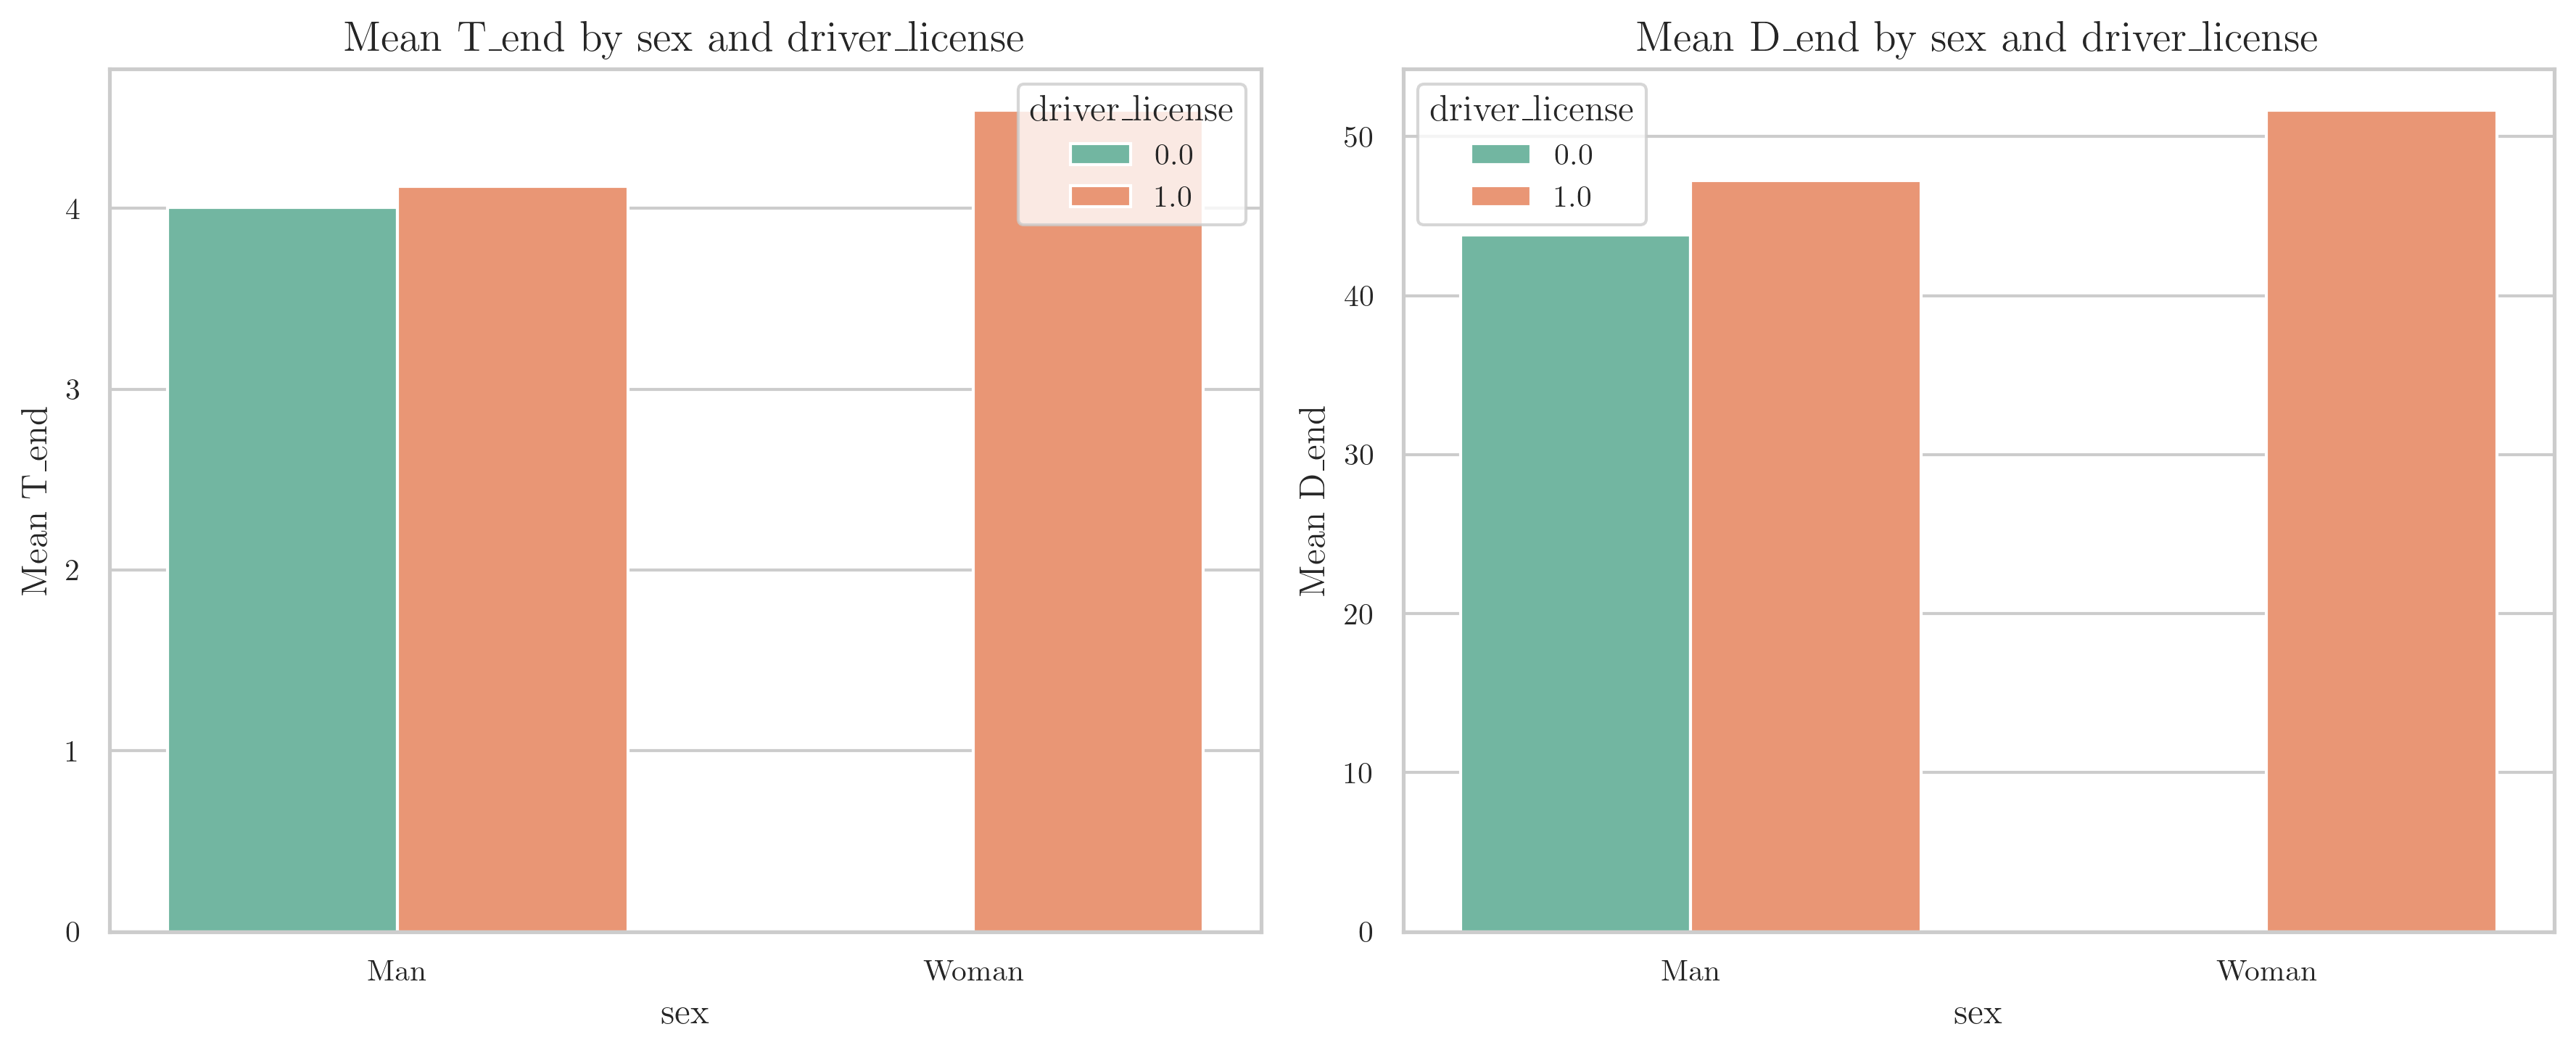


Crossed barplot of mean T_end by weather_id and velocity_id
velocity_cat weather_id   20 km/h   30 km/h   40 km/h   50 km/h   60 km/h  \
0                 clear  6.333326  5.150972  4.442402  4.109656  3.336355   
1                 night  7.576745  6.792673  4.335537  3.600926  3.076082   
2                  rain  6.355630  5.455480  4.294859  3.581138  3.304433   

velocity_cat   70 km/h  
0             2.974354  
1             2.916159  
2             2.791529  

Crossed barplot of mean D_end by weather_id and velocity_id
velocity_cat weather_id    20 km/h    30 km/h    40 km/h    50 km/h  \
0                 clear  35.185143  42.924766  49.360027  57.078552   
1                 night  42.093027  56.605607  48.172634  50.012859   
2                  rain  35.309057  45.462337  47.720660  49.738022   

velocity_cat    60 km/h    70 km/h  
0             55.605910  57.834670  
1             51.268030  56.703096  
2             55.073883  54.279722  


C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()


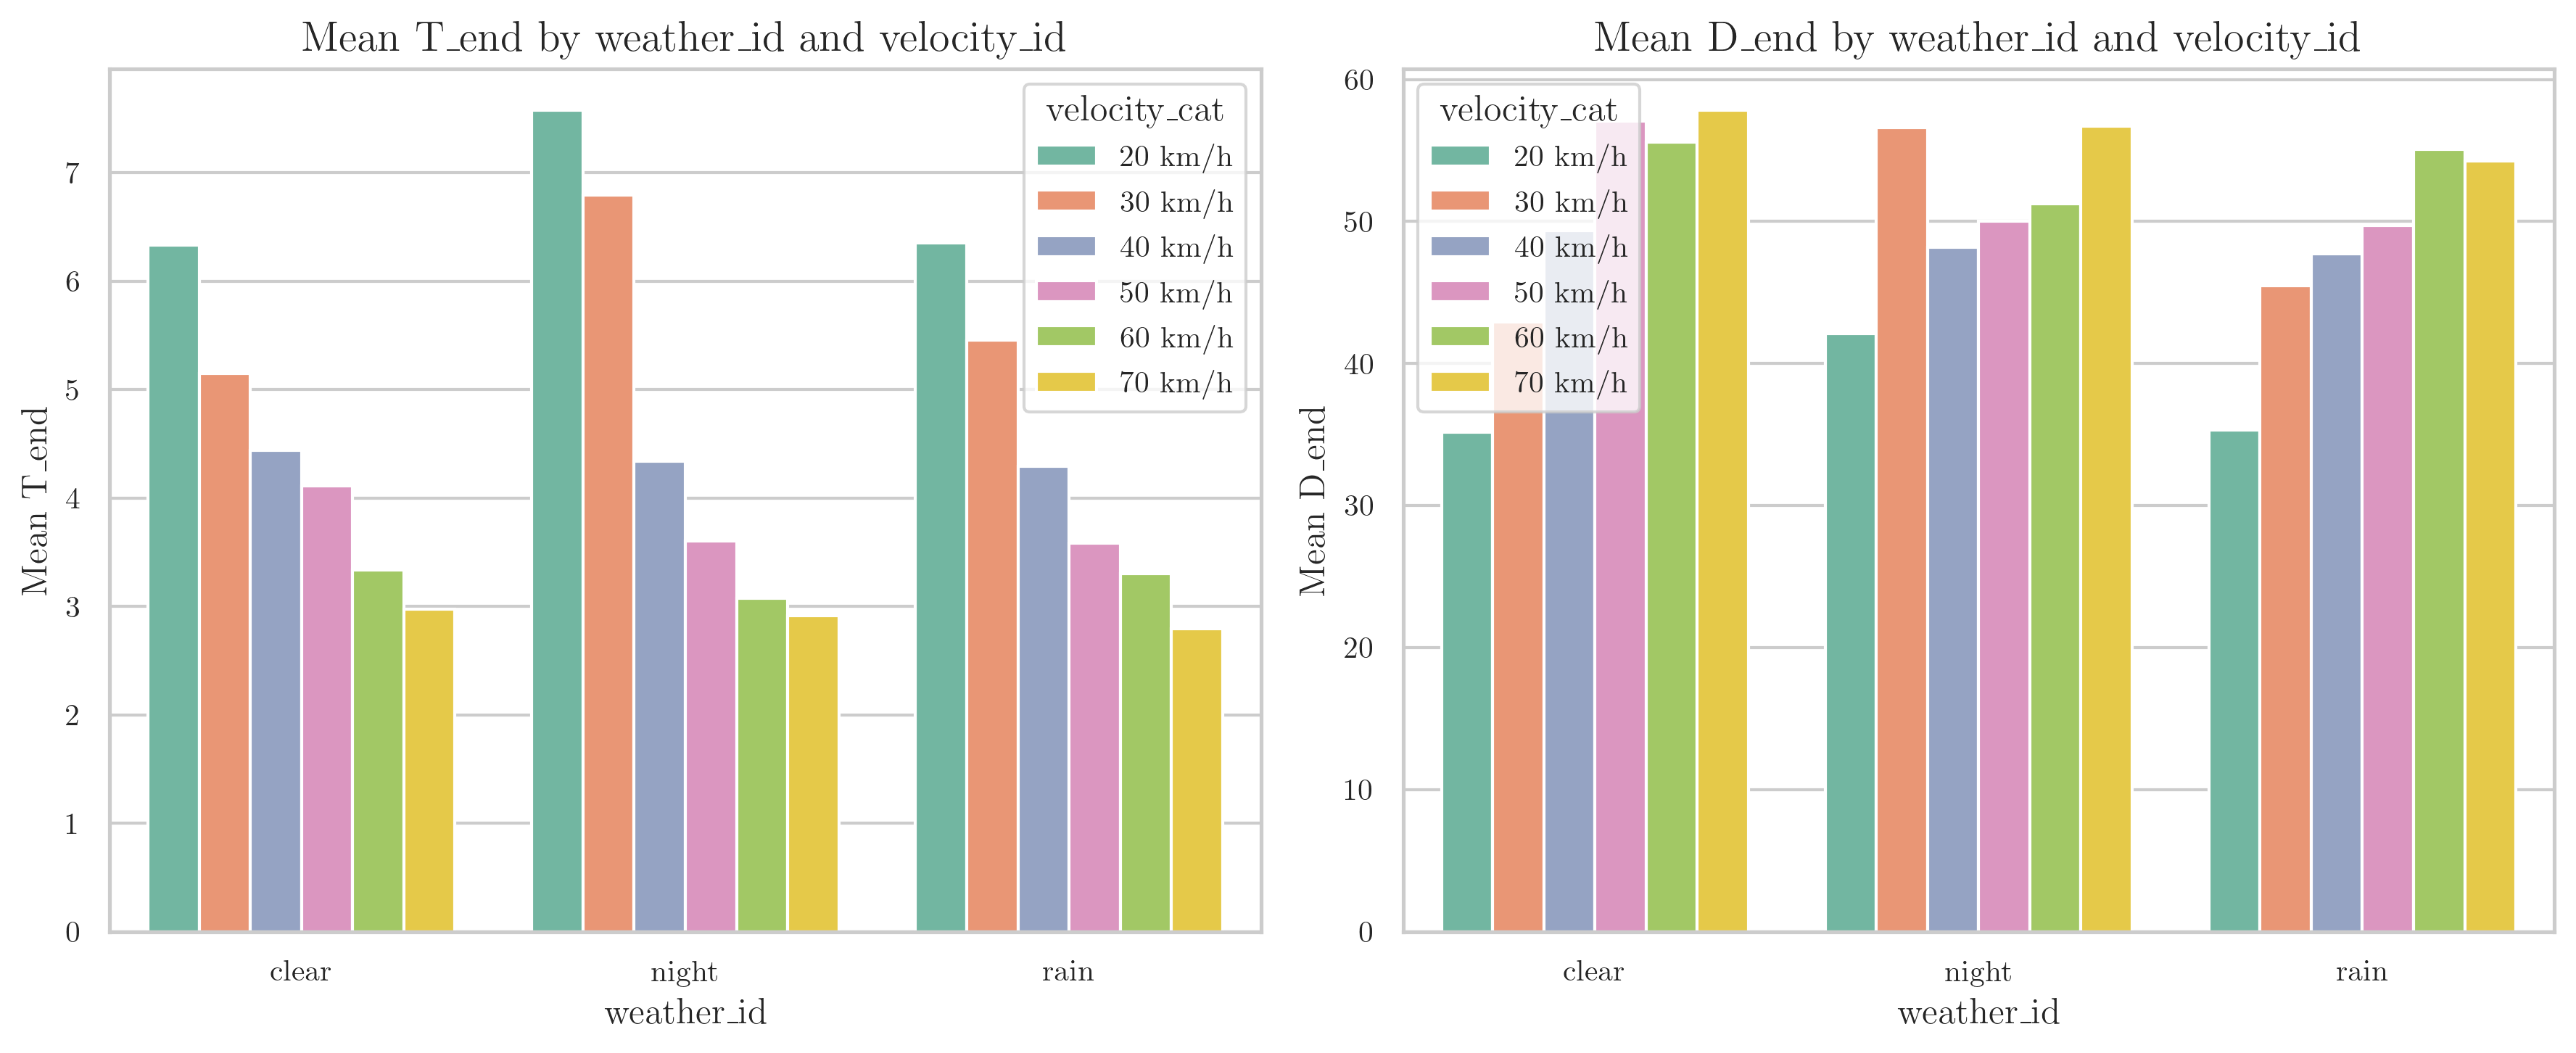


Crossed barplot of mean T_end by weather_id and height
Height_bin weather_id  (156.999, 167.0]  (167.0, 171.0]  (171.0, 176.0]  \
0               clear          4.936140        3.606205        3.521545   
1               night          5.701511        4.160606        3.501720   
2                rain          5.246877        3.739495        3.291193   

Height_bin  (176.0, 180.0]  (180.0, 190.0]  
0                 4.335869        4.381534  
1                 4.592625        4.116089  
2                 4.393736        3.888577  

Crossed barplot of mean D_end by weather_id and height
Height_bin weather_id  (156.999, 167.0]  (167.0, 171.0]  (171.0, 176.0]  \
0               clear         59.856638       39.099819       41.132604   
1               night         65.380900       41.124333       41.467785   
2                rain         60.780878       39.016611       39.791344   

Height_bin  (176.0, 180.0]  (180.0, 190.0]  
0                44.454259       56.267315  
1               

C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()



Crossed barplot of mean T_end by weather_id and age
Age_bin weather_id  (20.999, 26.0]  (26.0, 27.0]  (27.0, 32.0]  (32.0, 62.0]
0            clear        4.224558      4.098968      3.682762      4.615473
1            night        4.598425      4.143439      3.773793      5.011312
2             rain        4.167063      3.658780      3.445736      5.019279

Crossed barplot of mean D_end by weather_id and age
Age_bin weather_id  (20.999, 26.0]  (26.0, 27.0]  (27.0, 32.0]  (32.0, 62.0]
0            clear       50.979056     48.786883     44.034367     48.939572
1            night       52.548127     46.207606     43.396085     51.128823
2             rain       49.155289     42.807461     42.022748     51.637092


C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()



Crossed barplot of mean T_end by sex and velocity_id
velocity_cat    sex   20 km/h   30 km/h   40 km/h   50 km/h   60 km/h  \
0               Man  6.138936  4.953208  4.297209  3.597634  2.999024   
1             Woman  5.781311  6.857834  4.178536  3.971746  3.307454   

velocity_cat   70 km/h  
0             2.790162  
1             3.026905  

Crossed barplot of mean D_end by sex and velocity_id
velocity_cat    sex    20 km/h    30 km/h    40 km/h    50 km/h    60 km/h  \
0               Man  34.105203  41.276731  47.746769  49.967144  49.983734   
1             Woman  32.118396  57.148619  46.428181  55.163144  55.124233   

velocity_cat    70 km/h  
0             54.253153  
1             58.856491  


C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()



Crossed barplot of mean T_end by sex and height
Height_bin    sex  (156.999, 167.0]  (167.0, 171.0]  (171.0, 176.0]  \
0             Man               NaN        4.281614        3.257737   
1           Woman          5.291042        2.943078        3.798984   

Height_bin  (176.0, 180.0]  (180.0, 190.0]  
0                 4.706791        4.128733  
1                 3.920244             NaN  

Crossed barplot of mean D_end by sex and height
Height_bin    sex  (156.999, 167.0]  (167.0, 171.0]  (171.0, 176.0]  \
0             Man               NaN       41.750909       42.337972   
1           Woman         61.974599       35.738944       37.715789   

Height_bin  (176.0, 180.0]  (180.0, 190.0]  
0                46.067030       52.606368  
1                40.657507             NaN  


C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()


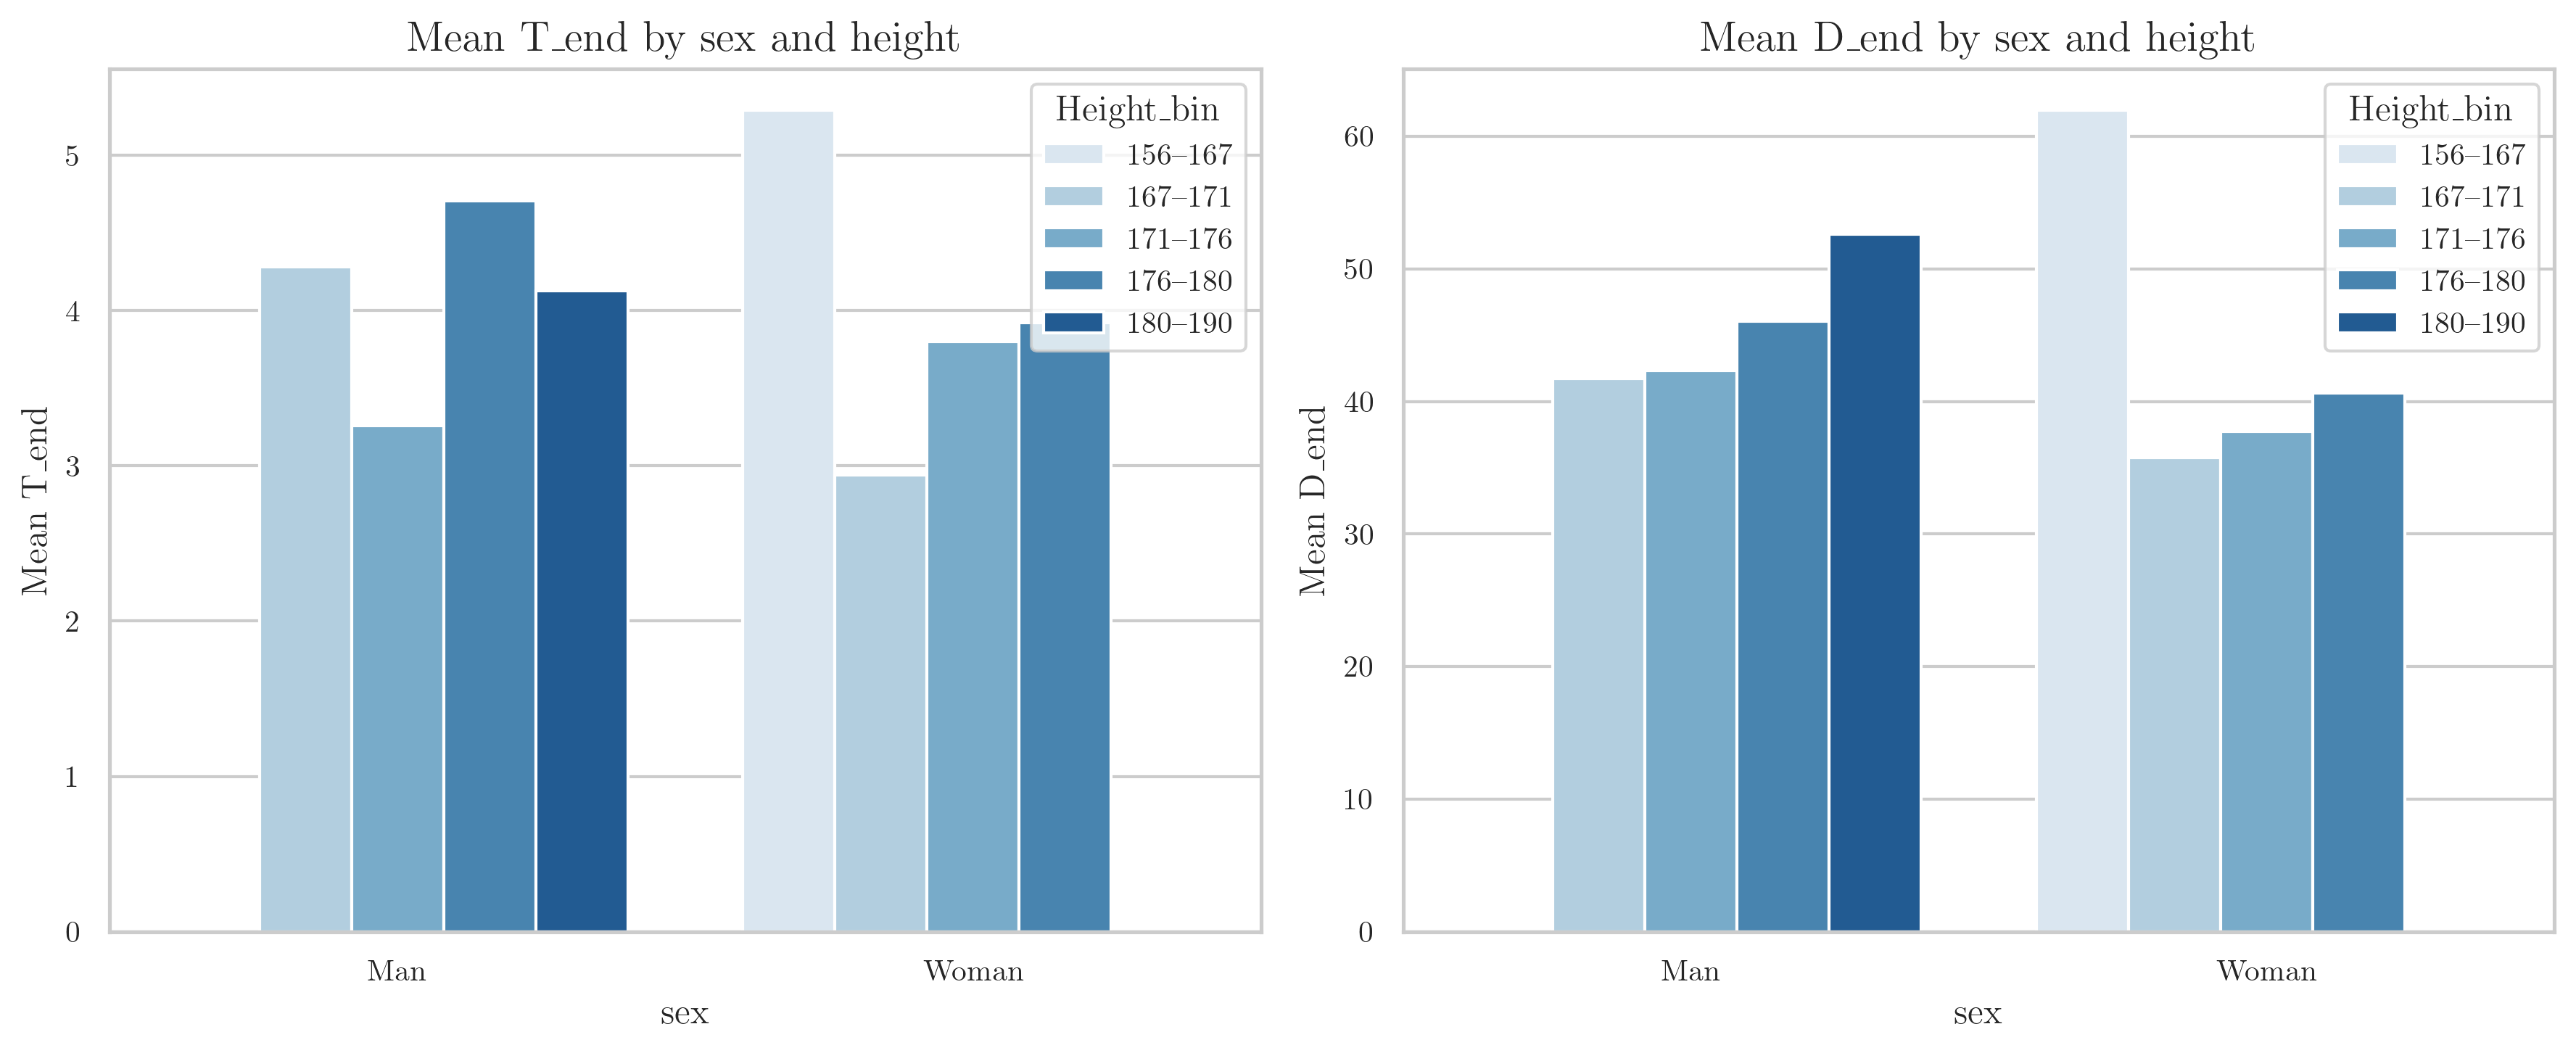


Crossed barplot of mean T_end by sex and age
Age_bin    sex  (20.999, 26.0]  (26.0, 27.0]  (27.0, 32.0]  (32.0, 62.0]
0          Man        4.258251      4.013881      3.634097      4.912697
1        Woman        4.426827      3.920244           NaN      4.870052

Crossed barplot of mean D_end by sex and age
Age_bin    sex  (20.999, 26.0]  (26.0, 27.0]  (27.0, 32.0]  (32.0, 62.0]
0          Man       47.445921     51.210459     43.151067     47.734656
1        Woman       55.470702     40.657507           NaN     51.517912


C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()


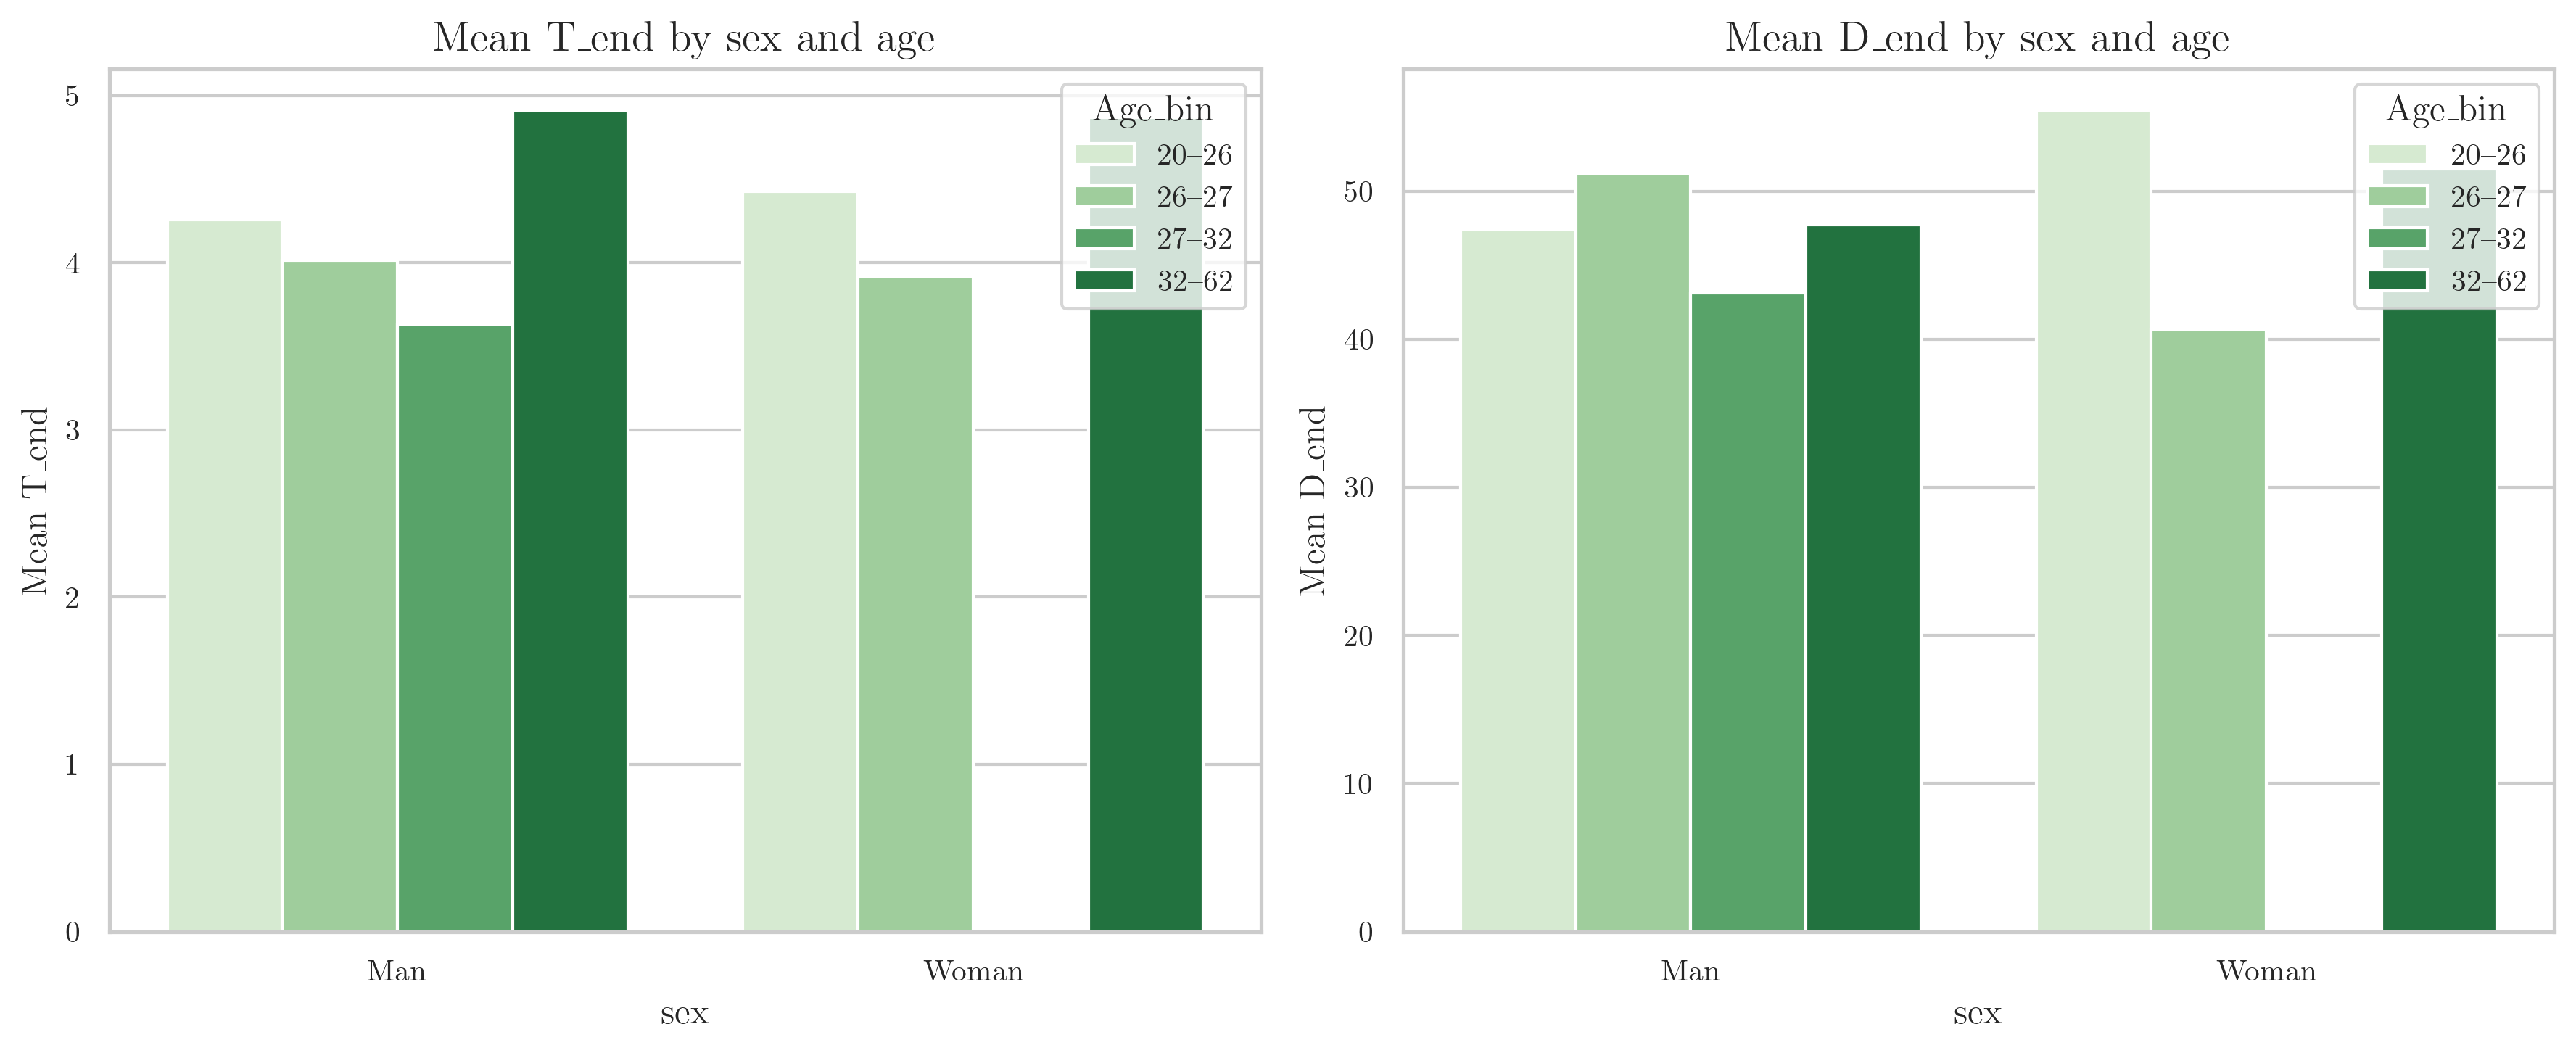


Crossed barplot of mean T_end by driver_license and velocity_id
velocity_cat  driver_license   20 km/h   30 km/h   40 km/h   50 km/h  \
0                        0.0  6.392450  5.130884  3.891544  3.576492   
1                        1.0  5.917872  5.883311  4.305484  3.787333   

velocity_cat   60 km/h   70 km/h  
0             2.245242  2.795193  
1             3.284149  2.906229  

Crossed barplot of mean D_end by driver_license and velocity_id
velocity_cat  driver_license    20 km/h    30 km/h    40 km/h   50 km/h  \
0                        0.0  35.513611  42.757367  43.239378  49.67350   
1                        1.0  32.877065  49.027596  47.838707  52.60185   

velocity_cat    60 km/h    70 km/h  
0             37.420700  54.350967  
1             54.735825  56.510006  


C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()



Crossed barplot of mean T_end by driver_license and height
Height_bin  driver_license  (156.999, 167.0]  (167.0, 171.0]  (171.0, 176.0]  \
0                      0.0               NaN        4.176412             NaN   
1                      1.0          5.291042        3.664947        3.438153   

Height_bin  (176.0, 180.0]  (180.0, 190.0]  
0                      NaN        3.834190  
1                 4.441331        4.276005  

Crossed barplot of mean D_end by driver_license and height
Height_bin  driver_license  (156.999, 167.0]  (167.0, 171.0]  (171.0, 176.0]  \
0                      0.0               NaN       38.724563             NaN   
1                      1.0         61.974599       40.258100       40.797244   

Height_bin  (176.0, 180.0]  (180.0, 190.0]  
0                      NaN       48.927278  
1                44.241316       54.445913  


C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()


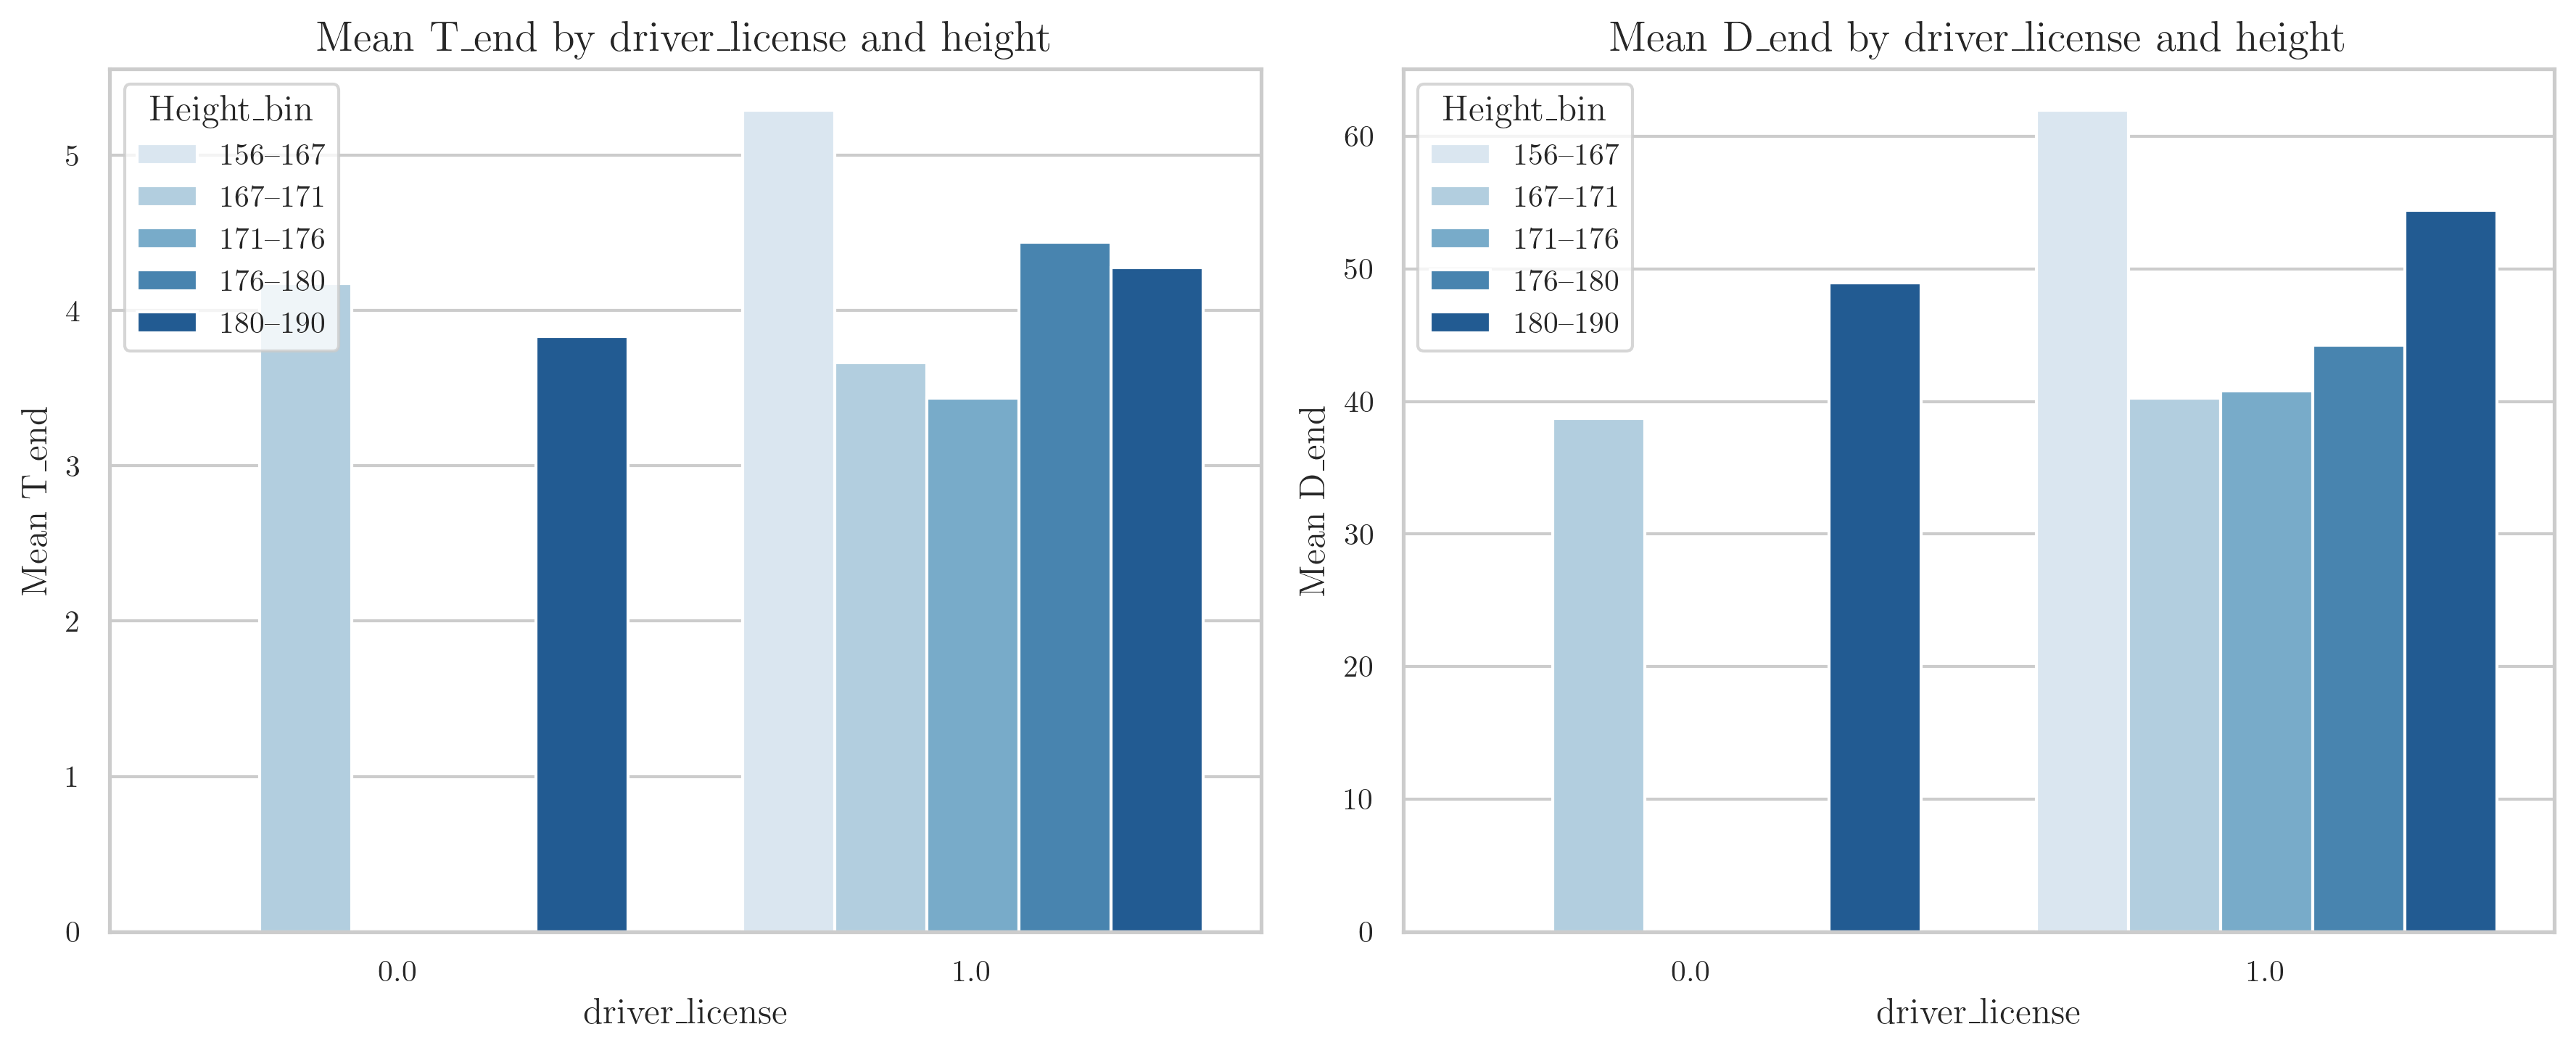


Crossed barplot of mean T_end by driver_license and age
Age_bin  driver_license  (20.999, 26.0]  (26.0, 27.0]  (27.0, 32.0]  \
0                   0.0        4.005301           NaN           NaN   
1                   1.0        4.462086      3.967062      3.634097   

Age_bin  (32.0, 62.0]  
0                 NaN  
1            4.880813  

Crossed barplot of mean D_end by driver_license and age
Age_bin  driver_license  (20.999, 26.0]  (26.0, 27.0]  (27.0, 32.0]  \
0                   0.0       43.825920           NaN           NaN   
1                   1.0       53.755528     45.933983     43.151067   

Age_bin  (32.0, 62.0]  
0                 NaN  
1           50.563259  


C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()



Crossed barplot of mean T_end by velocity_id and height
Height_bin velocity_cat  (156.999, 167.0]  (167.0, 171.0]  (171.0, 176.0]  \
0               20 km/h          7.285346        5.943305        5.283920   
1               30 km/h          7.596501        4.641833        4.171484   
2               40 km/h          5.501317        4.102428        3.256490   
3               50 km/h          4.522455        2.319620        3.000769   
4               60 km/h          3.857559        2.799110        2.856542   
5               70 km/h          3.428141        1.867780        2.600959   

Height_bin  (176.0, 180.0]  (180.0, 190.0]  
0                 5.814601             NaN  
1                      NaN        5.474357  
2                 4.253928             NaN  
3                      NaN        3.995545  
4                 3.209854             NaN  
5                      NaN        2.916298  

Crossed barplot of mean D_end by velocity_id and height
Height_bin velocity_cat  (156.9

C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()



Crossed barplot of mean T_end by velocity_id and age
Age_bin velocity_cat  (20.999, 26.0]  (26.0, 27.0]  (27.0, 32.0]  (32.0, 62.0]
0            20 km/h        6.093549      4.774668      5.494160      6.481251
1            30 km/h        5.989225      5.364719      4.171484      8.543564
2            40 km/h        4.093472      3.777802      4.313312      4.482129
3            50 km/h        4.006188      3.762669      3.000769      4.080011
4            60 km/h        2.718462      3.208261      3.352978      3.296374
5            70 km/h        2.996267      2.914257      2.600959      2.952676

Crossed barplot of mean D_end by velocity_id and age
Age_bin velocity_cat  (20.999, 26.0]  (26.0, 27.0]  (27.0, 32.0]  (32.0, 62.0]
0            20 km/h       33.853050     26.525933     30.523111     36.006952
1            30 km/h       49.910209     44.705989     34.762367     71.196364
2            40 km/h       45.483022     41.975578     47.925689     49.801437
3            50 km/h   

C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()


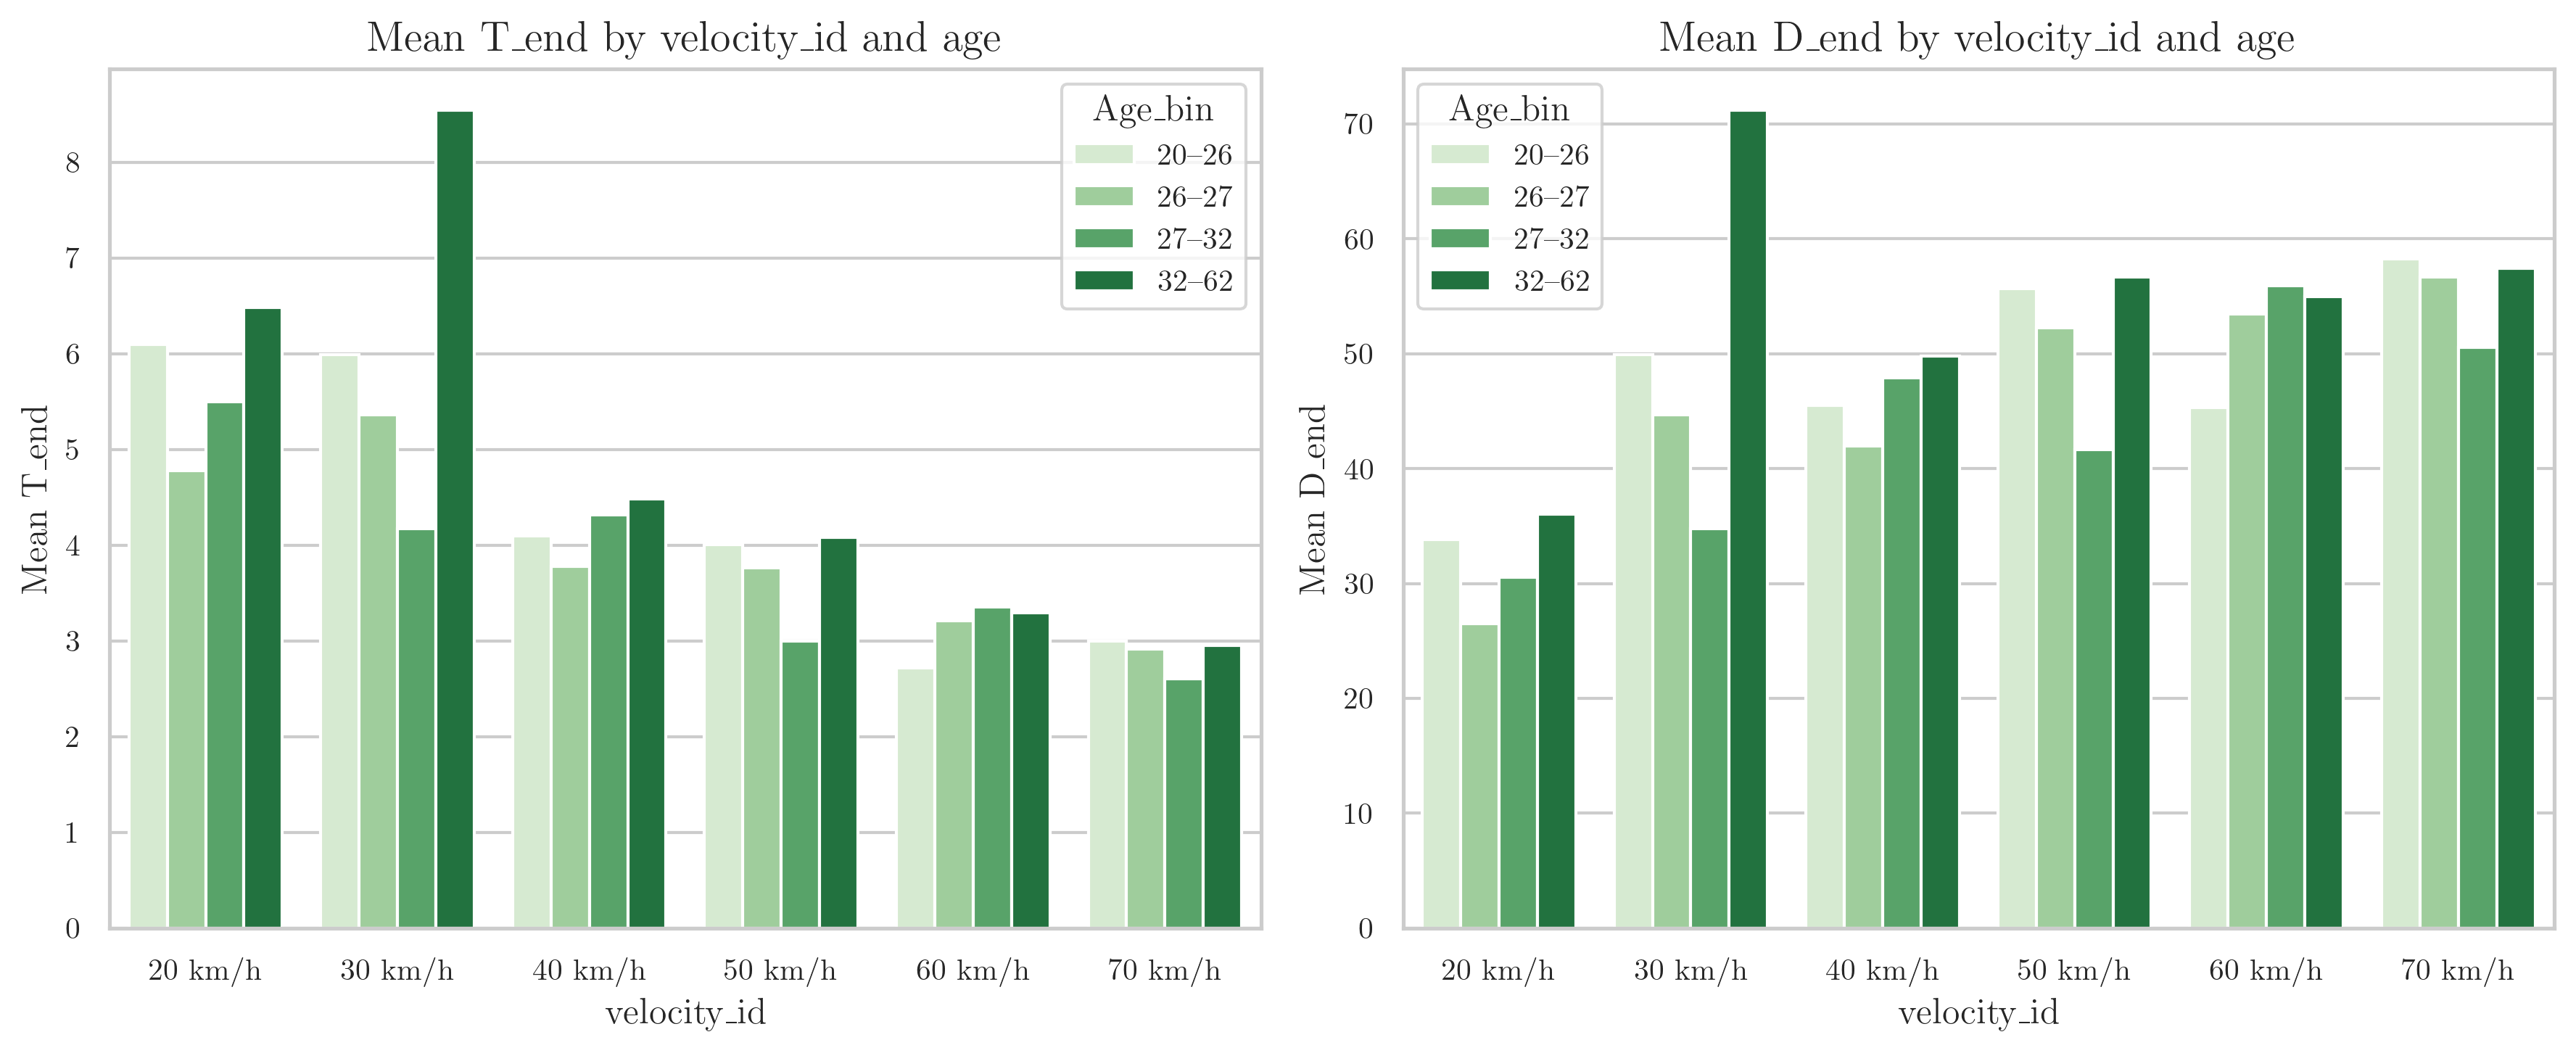


Crossed barplot of mean T_end by height and age
Age_bin        Height_bin  (20.999, 26.0]  (26.0, 27.0]  (27.0, 32.0]  \
0        (156.999, 167.0]        5.168702           NaN           NaN   
1          (167.0, 171.0]        3.559745           NaN      4.386817   
2          (171.0, 176.0]             NaN           NaN      3.257737   
3          (176.0, 180.0]        4.492965      3.920244           NaN   
4          (180.0, 190.0]        4.186159      4.013881           NaN   

Age_bin  (32.0, 62.0]  
0            5.415690  
1                 NaN  
2            3.798984  
3            4.912697  
4                 NaN  

Crossed barplot of mean D_end by height and age
Age_bin        Height_bin  (20.999, 26.0]  (26.0, 27.0]  (27.0, 32.0]  \
0        (156.999, 167.0]       65.336581           NaN           NaN   
1          (167.0, 171.0]       37.231754           NaN     44.777256   
2          (171.0, 176.0]             NaN           NaN     42.337972   
3          (176.0, 180.0]  

C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3294907609.py:45: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = df.pivot_table(values=var, index=binned_cat1, columns=binned_cat2, aggfunc='mean').reset_index()


In [360]:
for (cat1, cat2) in crosses:
    pal1 = None
    pal2 = None
    if cat1 == 'weather_id':
        pal1 = weather_palette
    elif cat1 == 'sex':
        pal1 = binary_palette
    elif cat1 == 'velocity_id':
        pal1 = velocity_palette
    elif cat1 == 'age':
        pal1 = age_palette
    elif cat1 == 'height':
        pal1 = height_palette

    if cat2 == 'weather_id':
        pal2 = weather_palette
    elif cat2 == 'sex':
        pal2 = binary_palette
    elif cat2 == 'velocity_id':
        pal2 = velocity_palette
    elif cat2 == 'age':
        pal2 = age_palette
    elif cat2 == 'height':
        pal2 = height_palette

    mean_cross_table(df, variables, cat1, cat2, palette_cat1=pal1, palette_cat2=pal2)


# Outliers

In [361]:
def plot_outliers(df, vars_list):
    colors = {"T_end": "#1f77b4",  # bleu
              "D_end": "#ff7f0e"}  # orange

    n = len(vars_list)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5))
    if n == 1:
        axes = [axes]

    for ax, var in zip(axes, vars_list):
        print(f"\nOutlier detection for {var}")
        sns.boxplot(x=df[var], color=colors.get(var, "gray"), ax=ax)
        ax.set_title(f"Outliers of {var}")

        Q1 = df[var].quantile(0.25)
        Q3 = df[var].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[var] < Q1 - 1.5 * IQR) | (df[var] > Q3 + 1.5 * IQR)]
        print(f"Number of outliers in {var}: {len(outliers)}")

    plt.tight_layout()
    plt.show()


##  Détection des valeurs aberrantes (Outliers)

Avant toute modélisation statistique ou interprétation fine, il est essentiel de vérifier si certaines observations extrêmes (« outliers ») peuvent influencer les résultats.  
Dans le cadre de l'Expérience 2, nous inspectons deux variables centrales :

- **T_end** : temps limite avant l’arrivée de la voiture (secondes)  
- **D_end** : distance limite (mètres)

Ces mesures reflètent directement le comportement de décision du participant au moment critique du crossing.  
Des valeurs aberrantes peuvent provenir de :

- comportements atypiques d’un participant,  
- erreurs de saisie,  
- artefacts de calcul,  
- ou, plus rarement, de cas extrêmes mais réels.


##  Objectif de la fonction `plot_outliers()`

Cette fonction :

1. **Dessine un boxplot** pour chaque variable (T_end, D_end)  
2. **Identifie les outliers via la règle classique de Tukey** :  
   \[
   \text{Outlier} \quad \text{si} \quad x < Q1 - 1.5\cdot IQR \quad \text{ou} \quad x > Q3 + 1.5\cdot IQR
   \]
3. **Compte le nombre d’observations extrêmes**
4. Affiche visuellement leur distribution


## Interprétation

- Le **boxplot** montre la répartition des valeurs, la médiane, et les points extrêmes.  
- Si un nombre important d’outliers apparaît, cela peut indiquer :
  - une forte variabilité inter-individuelle,
  - une hétérogénéité des conditions selon les scénarios,
  - ou la nécessité d’ajouter des filtres ou transformations (log, winsorisation, etc.).

Dans nos données, les outliers ne sont **pas supprimés** automatiquement :  
ils sont signalés afin d’aider à la discussion scientifique et éviter une interprétation biaisée.


##  Exécution

La cellule suivante applique cette détection :

```python
plot_outliers(df, ["T_end", "D_end"])
````

Cela génère deux boxplots côte à côte et affiche le nombre d’outliers détectés dans chaque variable.

```

In [362]:
plot_outliers(df, ["T_end", "D_end"])


Outlier detection for T_end
Number of outliers in T_end: 27

Outlier detection for D_end
Number of outliers in D_end: 12


##  Synthèse statistique récapitulative

Cette section fournit un **résumé statistique complet** pour chaque variable clé du comportement de crossing :

- **T_end** : temps limite avant l’arrivée du véhicule  
- **D_end** : distance limite (mètres)

L'objectif est de **comprendre comment ces variables varient en fonction de différents facteurs**, qu'ils soient continus ou catégoriels :

- **Variables continues** :  
  - âge  
  - taille  
  - vitesse du véhicule  

- **Variables binaires** :  
  - sexe  
  - possession du permis  

- **Variables catégorielles** :  
  - météo  

Pour permettre une analyse plus robuste, l’âge et la taille ont été discrétisés en **intervalles (Age_bin et Height_bin)**, ce qui rend possible un regroupement homogène par catégorie.


##  Fonction `summary_tables()`

La fonction :

1. **Ajoute automatiquement la bonne variable de regroupement**,  
   par exemple :
   - `age` → `Age_bin`
   - `height` → `Height_bin`
   - `velocity_id` → reste numérique
2. Calcule pour chaque groupe :
   - effectif  
   - moyenne  
   - écart-type  
   - médiane  
   - min / max  
3. Pour les variables numériques (âge, taille, vitesse),  
   elle calcule également les **corrélations Pearson et Spearman** entre :
   \[
   \text{groupe} \quad\text{et}\quad T_{end} / D_{end}
   \]
4. Elle gère automatiquement les cas où il n’y a **pas assez de variabilité** pour calculer une corrélation.


##  Interprétation

Cette synthèse permet :

- d’évaluer l’influence potentielle de chaque facteur sur **T_end** et **D_end**,  
- d’identifier les tendances globales,  
- de repérer d’éventuelles relations linéaires ou monotones,  
- de comparer les comportements entre sous-groupes (ex : hommes vs femmes, permis vs non-permis).

Ces résultats servent ensuite de base pour :

- la discussion scientifique dans le manuscrit,
- la validation des hypothèses comportementales,
- le choix des variables pertinentes dans la modélisation finale.


## Exécution

La boucle suivante génère automatiquement toutes les synthèses :

```python
for var in variables:
    summary_tables(df, var, all_group_vars)


In [363]:
def summary_tables(df, var, group_vars):
    from scipy.stats import pearsonr, spearmanr

    def get_group_column(col):
        if col == 'age' and 'Age_bin' in df.columns:
            return 'Age_bin'
        elif col == 'height' and 'Height_bin' in df.columns:
            return 'Height_bin'
        else:
            return col

    for group in group_vars:
        group_col = get_group_column(group)
        print(f"\nSummary statistics of {var} by {group_col}")
        summary = df.groupby(group_col)[var].agg(['count', 'mean', 'std', 'median', 'min', 'max'])
        print(summary)

        # Corrélation seulement si variable numérique
        corr_col = group if group in ['age', 'height'] else group_col

        if pd.api.types.is_numeric_dtype(df[corr_col]) and pd.api.types.is_numeric_dtype(df[var]):
            valid_data = df[[corr_col, var]].dropna()
            if valid_data[corr_col].nunique() > 1 and valid_data[var].nunique() > 1:
                pearson, p_pearson = pearsonr(valid_data[corr_col], valid_data[var])
                spearman, p_spearman = spearmanr(valid_data[corr_col], valid_data[var])
                print(f"\nPearson r between {corr_col} and {var}: {pearson:.3f} (p = {p_pearson:.3f})")
                print(f"Spearman rho between {corr_col} and {var}: {spearman:.3f} (p = {p_spearman:.3f})")
            else:
                print(f"\nNot enough variation to compute correlation between {corr_col} and {var}.")
        else:
            print(f"\nSkipping correlation for non-numeric variable {corr_col}.")


In [364]:
for var in variables:
    summary_tables(df, var, all_group_vars)


Summary statistics of T_end by velocity_id
             count      mean       std    median       min        max
velocity_id                                                          
20.0            90  6.755234  2.822117  6.063111  3.315636  17.303454
30.0            81  5.799708  2.897177  5.299236  0.197722  18.445080
40.0            89  4.357848  1.287121  4.250061  2.301120   8.961804
50.0            81  3.763906  1.432547  3.654929  0.835855   7.307928
60.0            89  3.238221  0.813069  3.219090  0.866328   4.967454
70.0            80  2.893737  1.038606  2.869033  0.825567   5.298583

Pearson r between velocity_id and T_end: -0.575 (p = 0.000)
Spearman rho between velocity_id and T_end: -0.639 (p = 0.000)

Summary statistics of T_end by Height_bin
                  count      mean       std    median       min        max
Height_bin                                                                
(156.999, 167.0]    107  5.291042  2.566128  4.909968  0.197722  12.651960
(167

C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\2634325279.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(group_col)[var].agg(['count', 'mean', 'std', 'median', 'min', 'max'])
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\2634325279.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(group_col)[var].agg(['count', 'mean', 'std', 'median', 'min', 'max'])
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\2634325279.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=

##  Analyse typique : comparaison descriptive de T_end et D_end

Cette dernière section propose une **analyse comparative approfondie** entre :

- **T_end** : seuil temporel de sécurité (en secondes)
- **D_end** : seuil spatial de sécurité (en mètres)

La fonction `descriptives_comparatives()` permet de :

###  1. Résumer statistiquement chaque variable  
Pour **T_end** et **D_end**, la fonction affiche :
- moyenne, médiane  
- quartiles (Q1–Q3)  
- min / max  
- test de normalité de Shapiro–Wilk  

Cela permet de vérifier si les distributions sont symétriques, étalées ou potentiellement biaisées.

###  2. Visualiser la distribution avec histograms + KDE  
Pour chaque variable, la fonction trace :
- un **histogramme**
- la **densité estimée KDE**
- un **trait vertical indiquant le mode KDE** (= valeur la plus fréquente)

Cela est utile pour vérifier :
- si la distribution est unimodale / bimodale  
- si T_end ou D_end présentent un pic marqué (ex. autour de 2–3 s)  
- si les participants adoptent des stratégies cohérentes selon les conditions expérimentales  

###  3. Vérifier la normalité avec des **QQ-plots**
Pour chaque variable, un QQ-plot est généré afin d’évaluer :
- l’écart à une distribution normale  
- la présence d’asymétrie  
- d’éventuels heavy tails  

Cette étape est importante pour choisir correctement les tests statistiques (ANOVA vs non paramétriques).


## Exécution

La commande suivante réalise automatiquement toute l’analyse comparative :

```python
descriptives_comparatives(df, 'T_end', 'D_end')
````

Elle produit :

* 2 tableaux descriptifs
* 2 histogrammes KDE annotés
* 2 QQ-plots comparatifs

Cette analyse est particulièrement utile pour discuter :

* de la stratégie temporelle des piétons
* du lien entre perception et comportement de traversée
* de la variabilité inter-individuelle dans Expérience 2


In [369]:
def descriptives_table(df, variables):
    stats_df = df[variables].describe().T
    stats_df['median'] = df[variables].median()
    stats_df = stats_df[['count', 'mean', 'std', 'min', '25%', 'median', '75%', 'max']]
    return stats_df

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
def plot_histograms(df, var1, var2, color1="#1f77b4", color2="#ff7f0e"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for ax, var, color in zip(axes, [var1, var2], [color1, color2]):
        # Plot histogram + KDE (sans légende automatique)
        sns.histplot(df[var].dropna(), kde=True, color=color, ax=ax, legend=False)

        # Récupérer la ligne KDE créée (dernière ligne tracée)
        kde_line = None
        for line in ax.lines:
            # On cherche une ligne de la bonne couleur (celle du kde)
            if line.get_color() == color:
                kde_line = line
                break

        # Calcul du pic KDE
        kde = stats.gaussian_kde(df[var].dropna())
        x_vals = sorted(df[var].dropna())
        kde_vals = kde(x_vals)
        peak_x = x_vals[kde_vals.argmax()]

        # Médiane
        median_x = df[var].median()

        # Tracer les lignes verticales avec labels contenant les valeurs
        peak_label = f'KDE peak: {peak_x:.2f}'
        median_label = f'Median: {median_x:.2f}'
        peak_line = ax.axvline(peak_x, color='black', linestyle='--', label=peak_label)
        median_line = ax.axvline(median_x, color='red', linestyle=':', label=median_label)

        ax.set_title(f'{var} distribution')
        ax.set_xlabel(var)
        ax.set_ylabel('Density')

        # Construire la légende avec la ligne KDE + 2 lignes verticales
        handles = [kde_line, peak_line, median_line]
        labels = ['KDE curve', peak_label, median_label]
        ax.legend(handles, labels)

    plt.tight_layout()
    plt.show()


def scatter_with_regression(df, x_var, y_var):
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import pearsonr

    plt.figure(figsize=(8, 6))
    sns.set(style="whitegrid")
    ax = sns.regplot(data=df, x=x_var, y=y_var, ci=95, scatter_kws={'s': 30}, line_kws={'color': 'red'})

    r, p = pearsonr(df[x_var].dropna(), df[y_var].dropna())
    plt.text(0.05, 0.95, f'Pearson r = {r:.2f} (p = {p:.3g})',
             transform=ax.transAxes, fontsize=12, verticalalignment='top')

    plt.title(f'{y_var} vs {x_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.tight_layout()
    plt.show()

import statsmodels.api as sm

def plot_qqplots(df, var1, var2, color1="#1f77b4", color2="#ff7f0e"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, var, color in zip(axes, [var1, var2], [color1, color2]):
        sm.qqplot(df[var].dropna(), line='s', ax=ax, color=color)
        ax.set_title(f'QQ-Plot of {var}')
    plt.tight_layout()
    plt.show()


\begin{tabular}{lrrrrrrrr}
\toprule
 & count & mean & std & min & 25% & median & 75% & max \\
\midrule
T_end & 510.000000 & 4.490535 & 2.354610 & 0.197722 & 2.985535 & 3.994314 & 5.332412 & 18.445080 \\
D_end & 510.000000 & 49.296023 & 19.101274 & 1.647680 & 35.275725 & 46.866500 & 59.604075 & 153.709000 \\
\bottomrule
\end{tabular}



C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3932748425.py:47: UserWarning: Legend does not support handles for NoneType instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles, labels)
C:\Users\svictor\AppData\Local\Temp\ipykernel_25368\3932748425.py:47: UserWarning: Legend does not support handles for NoneType instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend(handles, labels)


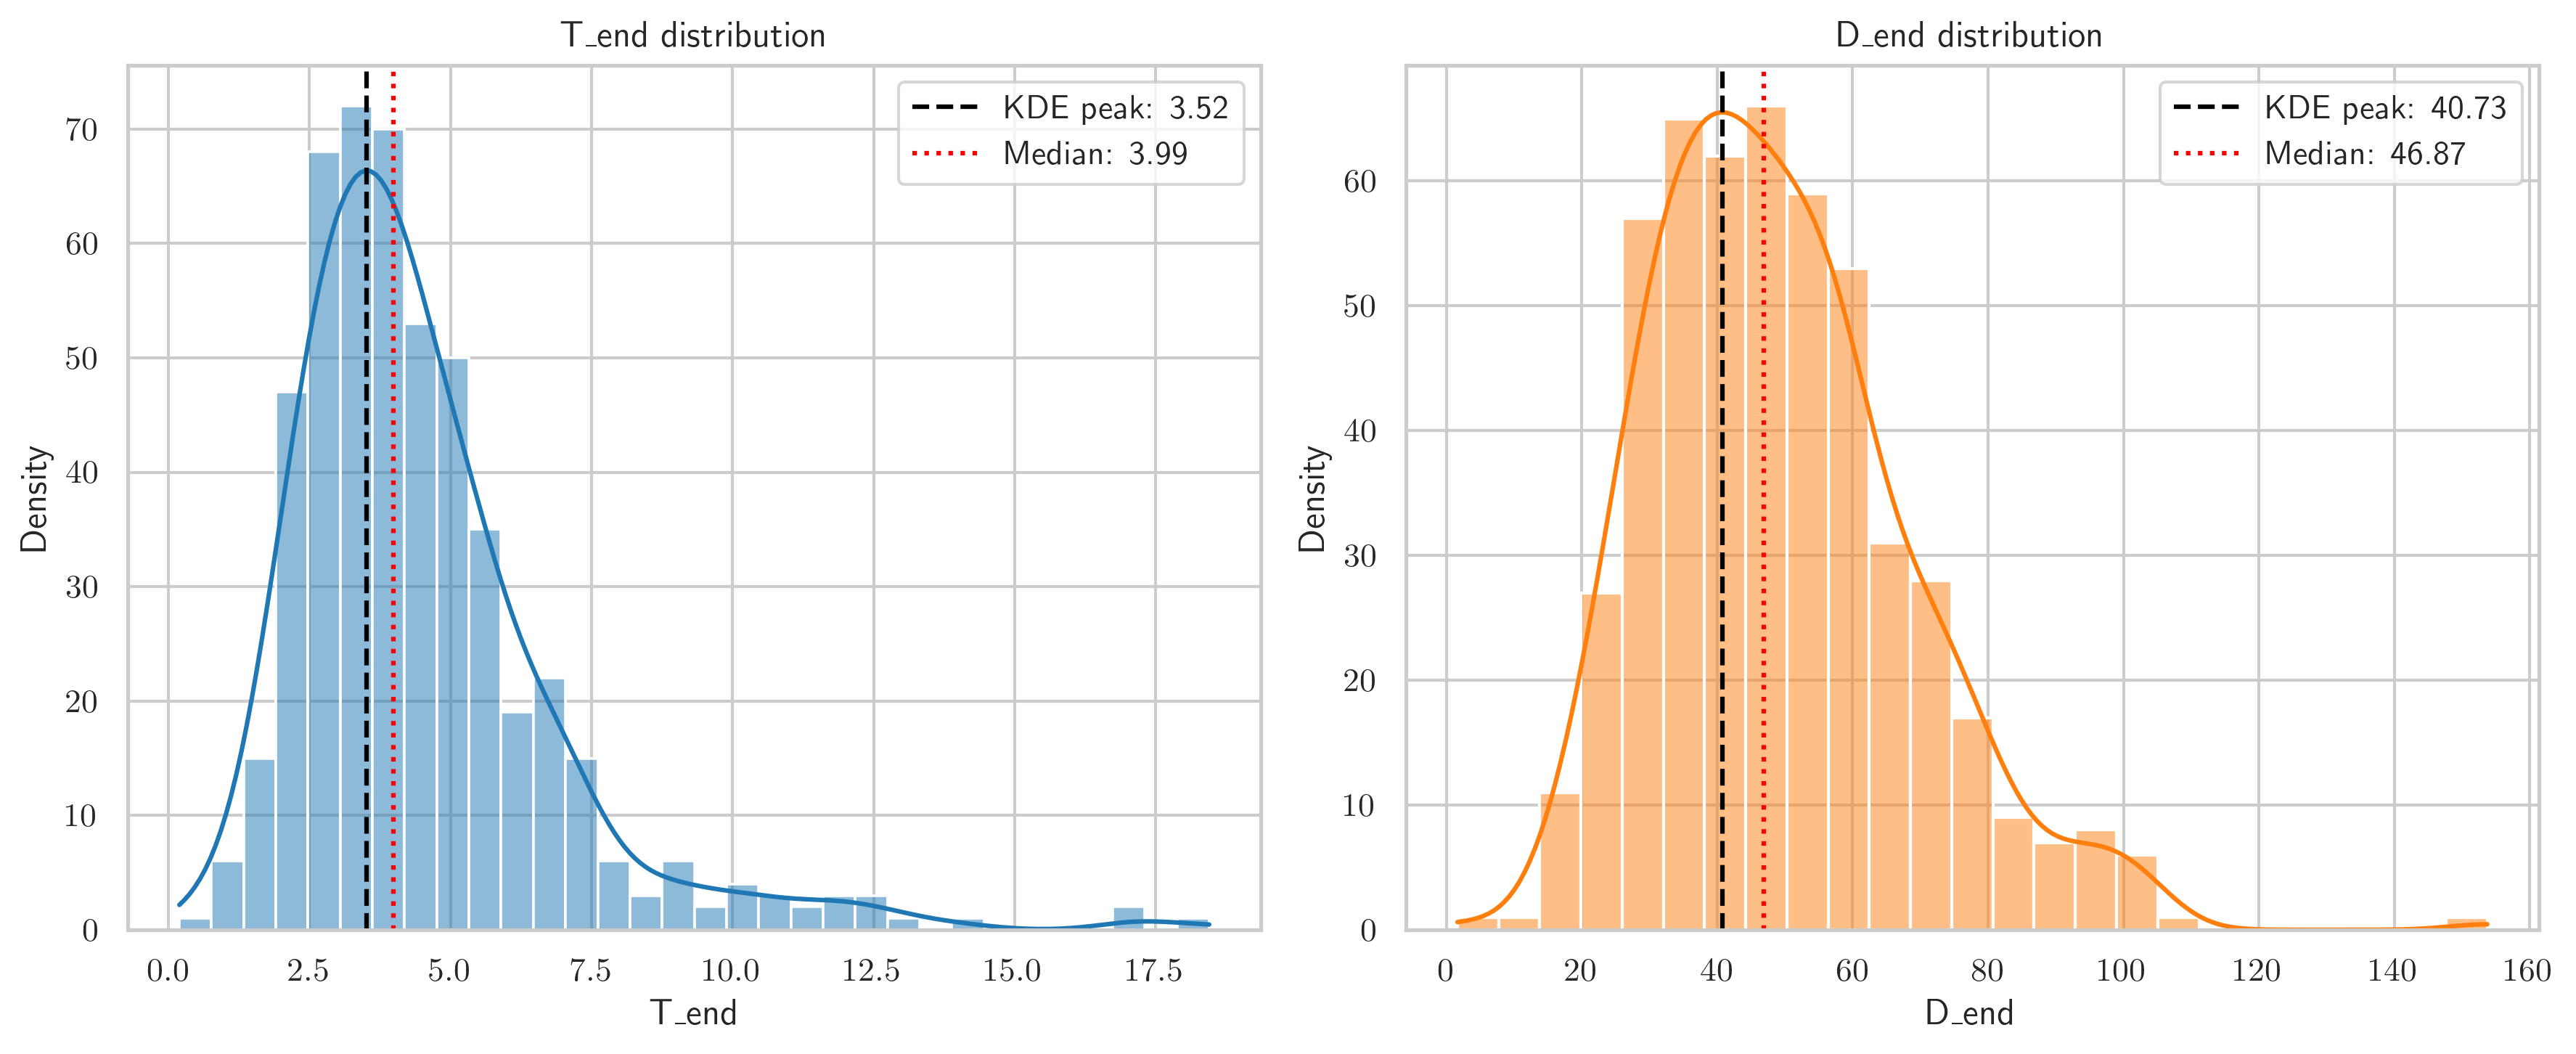

c:\Users\svictor\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


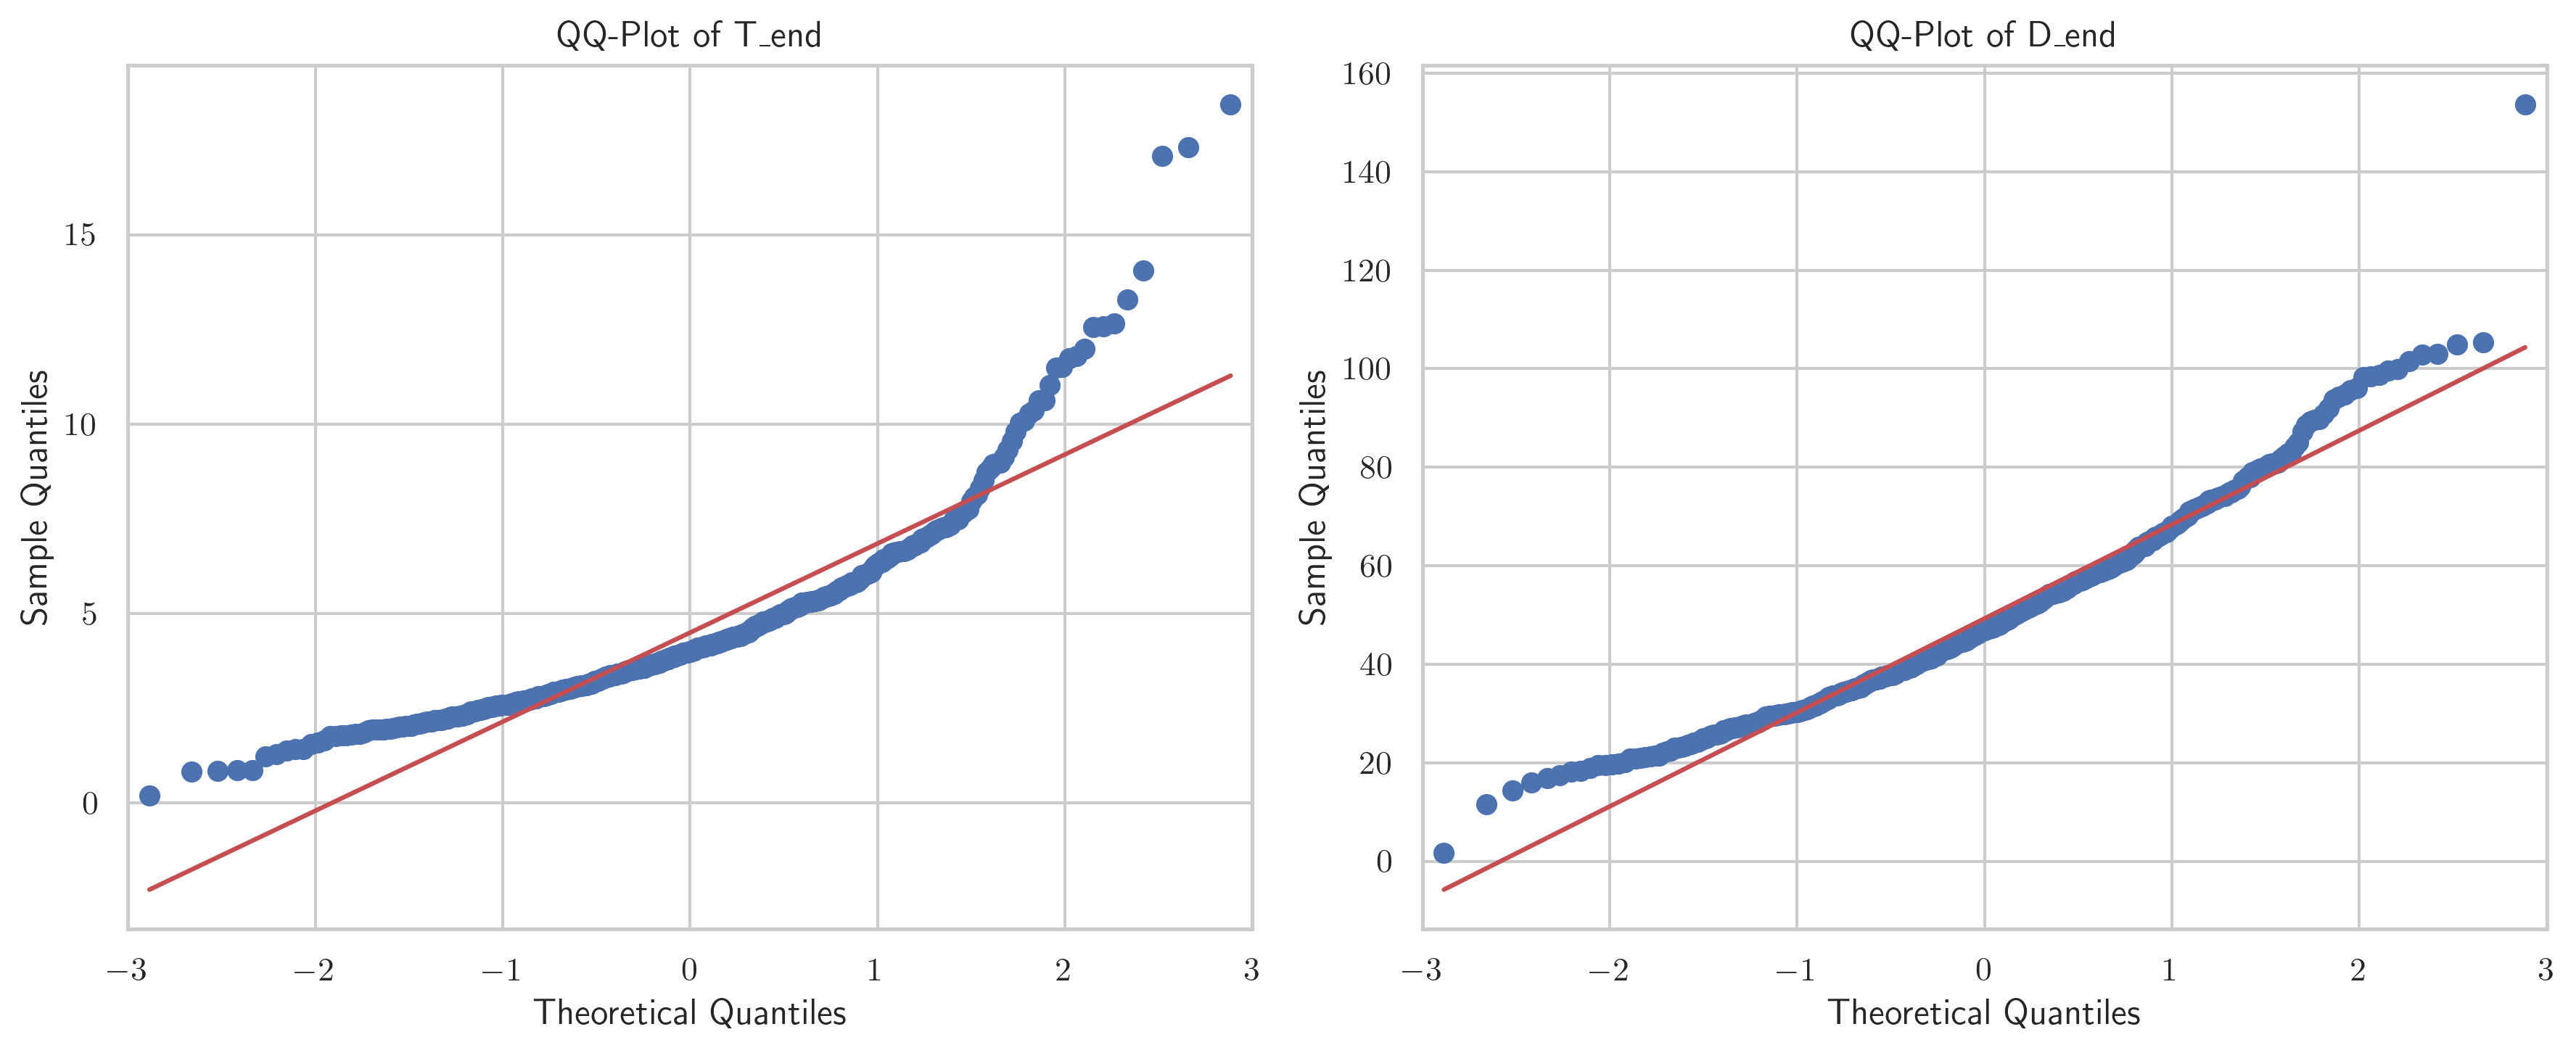

In [ ]:
# Tableau
stats_table = descriptives_table(df, ['T_end', 'D_end'])
print(stats_table.to_latex())  # pour insérer direct en LaTeX

# Histogrammes
plot_histograms(df, 'T_end', 'D_end')




# QQ-plots (optionnel pour annexes)
plot_qqplots(df, 'T_end', 'D_end')
